In [297]:
#%pip install scikit-learn



In [298]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re



In [299]:
df = pd.read_csv(r'c:\Users\Mango\Downloads\FinalEvAdoptionInFranceResults.csv')
print(list(df.columns))
def extract_after_newline_parentheses(col):
    match = re.search(r'\n\s*\((.*?)\)', col)
    if match:
        return match.group(1)
    match = re.search(r'\(([^()]*(?:\([^)]*\)[^()]*)*)\)\s*$', col)
    if match:
        return match.group(1)
    return None

def extract_before_newline_parentheses(col):
    match = re.search(r'^(.*?)\s*\n', col)
    if match:
        return match.group(1)
    match = re.search(r'^(.*?)\s*\(', col)
    if match:
        return match.group(1)
    return col
def get_labels_and_title(cols):
    labels = [extract_after_newline_parentheses(col) for col in cols]
    title = extract_before_newline_parentheses(cols[0])
    return labels, title


['Submission ID', 'Respondent ID', 'Submitted at', 'Combien êtes-vous dans votre foyer ?', 'Habitez-vous dans :', 'Avez-vous accès à une place de parking personnelle ?', 'Combien de véhicules personnels utilisez-vous dans votre foyer ?', "Pourquoi n'avez-vous pas de véhicule ?\n", "Pourquoi n'avez-vous pas de véhicule ?\n (Je n'ai pas de permis de conduire)", "Pourquoi n'avez-vous pas de véhicule ?\n (Les frais)", "Pourquoi n'avez-vous pas de véhicule ?\n (Je vis dans une zone bien desservie par les transports en commun)", "Pourquoi n'avez-vous pas de véhicule ?\n (Je n'ai pas besoin de voiture pour mes trajets quotidiens)", "Pourquoi n'avez-vous pas de véhicule ?\n (Le vélo, la marche ou d'autres moyens de transport me conviennent)", "Pourquoi n'avez-vous pas de véhicule ?\n (Je préfère ne pas être dépendant de la voiture)", "Pourquoi n'avez-vous pas de véhicule ?\n (Autre)", 'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n', 'Quels types de v

----
# Financial factors

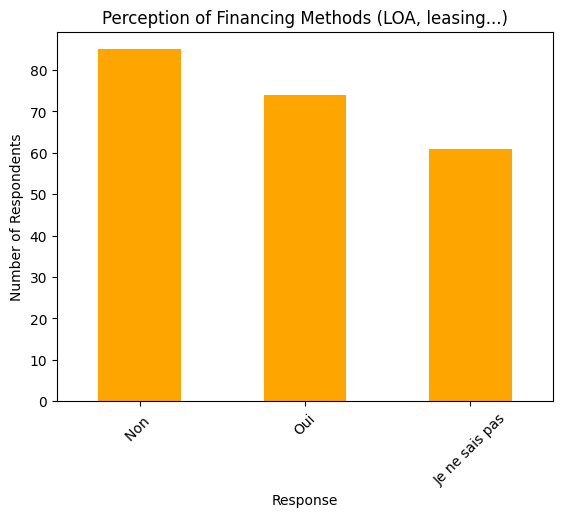

In [300]:
financing_col = "(Optionnel) Il existe plusieurs façons de financer un véhicule électrique: \nLOA (location avec option d’achat), la LLD (location longue durée), leasing social, crédit auto...\nL’une de ces options vous semblerait-elle adaptée à votre situation ?\n"

df[financing_col].value_counts().plot(kind='bar', color='orange')
plt.title("Perception of Financing Methods (LOA, leasing...)")
plt.xlabel("Response")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=45)
plt.show()


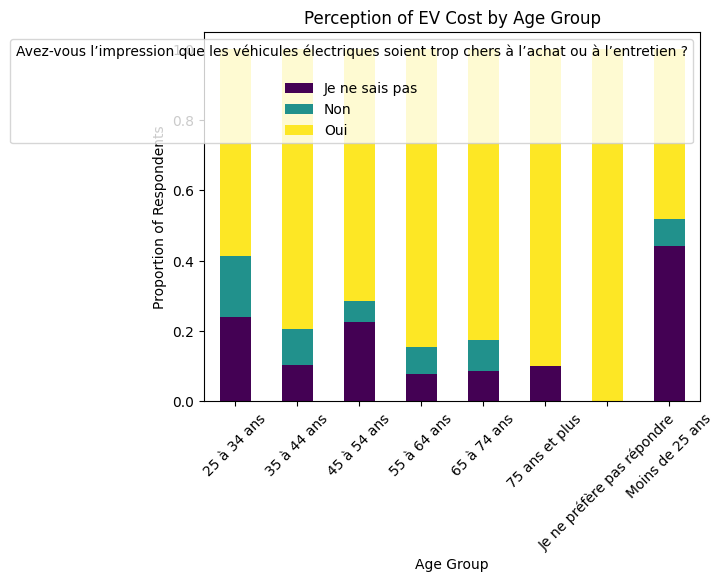

In [301]:
cost_perception_col = "Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"
age_col = "Dans quelle tranche d’âge vous situez-vous ?\n"

cost_by_age = df.groupby(age_col)[cost_perception_col].value_counts(normalize=True).unstack().fillna(0)

cost_by_age.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Perception of EV Cost by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Proportion of Respondents")
plt.xticks(rotation=45)
plt.show()

In [302]:
# Création de la variable propriétaire VE
df['is_EV_owner'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

# Moyenne du ressenti "VE trop cher" par groupe
grouped_cost = df.groupby('is_EV_owner')["Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"].value_counts(normalize=True).unstack()

print("🔍 Perception du coût par possession de VE :")
print(grouped_cost)


🔍 Perception du coût par possession de VE :
Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?
  Je ne sais pas  \
is_EV_owner                                                                                                            
False                                                                                                       0.226131   
True                                                                                                        0.151515   

Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?
       Non  \
is_EV_owner                                                                                                      
False                                                                                                 0.060302   
True                                                                                                  0.242424   

Avez-vous l’impres

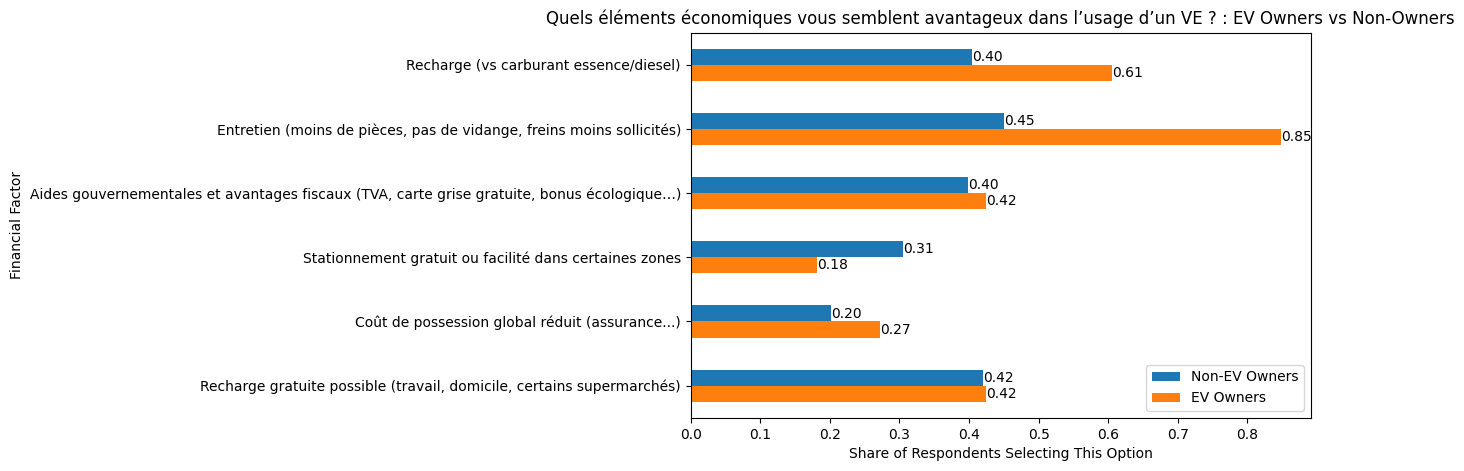

In [303]:
# Create a new column 'owns_ev' as boolean
df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True
economic_cols = [
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge (vs carburant essence/diesel))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Entretien (moins de pièces, pas de vidange, freins moins sollicités))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Stationnement gratuit ou facilité dans certaines zones)',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Coût de possession global réduit (assurance...))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge gratuite possible (travail, domicile, certains supermarchés))',
]
# Group by EV ownership and compute mean response per financial item
ownership_financial_comparison = df.groupby('owns_ev')[economic_cols].mean().T

labels, title = get_labels_and_title(ownership_financial_comparison.index)

ax = ownership_financial_comparison.plot(kind='barh', figsize=(8, 5))
plt.title(f"{title} : EV Owners vs Non-Owners")
plt.xlabel("Share of Respondents Selecting This Option")
plt.ylabel("Financial Factor")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.legend(['Non-EV Owners', 'EV Owners'], loc='lower right')
plt.gca().invert_yaxis()
# Add value labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
plt.show()

In [304]:
# Croisement entre perception coût et intention d’adopter (non-VE)
subset = df[df['is_EV_owner'] == False]
crosstab = pd.crosstab(
    subset["Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"],
    subset["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"]
)

print("📊 Corrélation entre coût perçu et intention d’adoption :")
print(crosstab)

# Pour tester l'association (optionnel)
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"\nTest du Chi² : p-value = {p:.4f}")

📊 Corrélation entre coût perçu et intention d’adoption :
Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]  \nPlutôt en désaccord\n\n  \
Avez-vous l’impression que les véhicules électr...                                                                                                                        
Je ne sais pas                                                                                                                                                        9   
Non                                                                                                                                                                   1   
Oui                                                                                                                                                                  32   

Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attir

📊 Pourcentage de répondants par zone ayant sélectionné chaque avantage (Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ?):
Habitez-vous dans :                                Une grande ville  \
Recharge (vs carburant essence/diesel)                    43.373494   
Entretien (moins de pièces, pas de vidange, fre...        46.987952   
Aides gouvernementales et avantages fiscaux (TV...        37.349398   
Stationnement gratuit ou facilité dans certaine...        37.349398   
Coût de possession global réduit (assurance...)           25.301205   
Recharge gratuite possible (travail, domicile, ...        48.192771   

Habitez-vous dans :                                Une ville moyenne  \
Recharge (vs carburant essence/diesel)                     48.484848   
Entretien (moins de pièces, pas de vidange, fre...         54.545455   
Aides gouvernementales et avantages fiscaux (TV...         43.939394   
Stationnement gratuit ou facilité dans certaine...         24.242

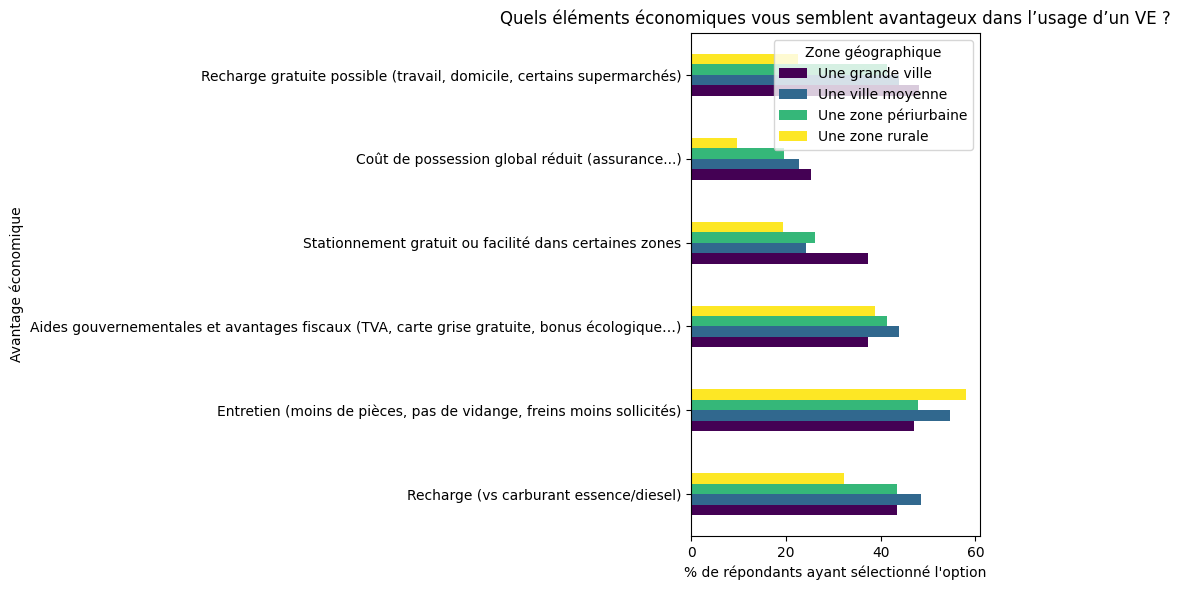

In [305]:
# Colonnes à analyser
geo_col = "Habitez-vous dans :"
economic_cols = [
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge (vs carburant essence/diesel))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Entretien (moins de pièces, pas de vidange, freins moins sollicités))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Aides gouvernementales et avantages fiscaux (TVA, carte grise gratuite, bonus écologique…))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Stationnement gratuit ou facilité dans certaines zones)',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Coût de possession global réduit (assurance...))',
    'Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique) (Recharge gratuite possible (travail, domicile, certains supermarchés))',
]

# Regrouper les réponses par origine géographique
grouped = df.groupby(geo_col)[economic_cols].mean().transpose()

# Mise en forme en pourcentage
grouped_percent = grouped * 100

# Récupérer les labels et le titre pour l'axe Y et le titre du graphique
labels, title = get_labels_and_title(grouped_percent.index)

# Affichage chiffré avec labels lisibles
print(f"📊 Pourcentage de répondants par zone ayant sélectionné chaque avantage ({title}):")
grouped_percent_labeled = grouped_percent.copy()
grouped_percent_labeled.index = labels
print(grouped_percent_labeled.round(1))

# Graphique
grouped_percent.plot(kind='barh', figsize=(10, 6), colormap='viridis')
plt.title(title)
plt.xlabel("% de répondants ayant sélectionné l'option")
plt.ylabel("Avantage économique")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.legend(title="Zone géographique")
plt.tight_layout()
plt.show()


In [306]:
# Tableau croisé
crosstab = pd.crosstab(
    df["Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"],
    df["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"]
)
print(crosstab)

# Test du Chi²
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"Test du Chi² : p-value = {p:.4f}")

Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]  \nPlutôt en désaccord\n\n  \
Avez-vous l’impression que les véhicules électr...                                                                                                                        
Je ne sais pas                                                                                                                                                        9   
Non                                                                                                                                                                   1   
Oui                                                                                                                                                                  32   

Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]  Pl

In [307]:
# Suppose que la colonne 'Perception coût' est codée numériquement (ex: 1=Oui, 0=Non)
# Sinon, il faut la recoder avant !
df['cout_trop_cher'] = df["Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"].map({'Oui':1, 'Non':0})

# ANOVA
groups = [g['cout_trop_cher'].dropna() for name, g in df.groupby("Dans quelle tranche d’âge vous situez-vous ?\n")]
f, p = stats.f_oneway(*groups)
print(f"ANOVA coût perçu par âge : p-value = {p:.4f}")

ANOVA coût perçu par âge : p-value = 0.6395


In [308]:
# Exemple de recodage (à adapter selon tes colonnes)
# Map all positive intention responses to 1, negative to 0
intention_map = {
	"Oui": 1,
	"Plutôt d'accord": 1,
	"Totalement d'accord": 1,
	"Non": 0,
	"Plutôt en désaccord": 0,
	"Totalement en désaccord": 0
}
df['intention_adopter'] = df["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"].map(intention_map)

df['connait_aides'] = df["Connaissez-vous des aides financières disponibles pour l’achat d’un véhicule électrique ? (Cochez tout ce que vous connaissez)\n"].notna().astype(int)

# Variables explicatives
X = df[['connait_aides', 'cout_trop_cher']].dropna()
y = df.loc[X.index, 'intention_adopter']

# Remove rows where y is NaN
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.673751
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      intention_adopter   No. Observations:                  121
Model:                          Logit   Df Residuals:                      119
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 May 2025   Pseudo R-squ.:                0.006282
Time:                        01:15:48   Log-Likelihood:                -81.524
converged:                       True   LL-Null:                       -82.039
Covariance Type:            nonrobust   LLR p-value:                    0.3100
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
connait_aides      0.9808      0.677      1.449      0.147      -0.346       2.308
cout_trop_cher   

count    232.000000
mean       1.534483
std        1.385959
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        6.000000
Name: score_aides_connues, dtype: float64


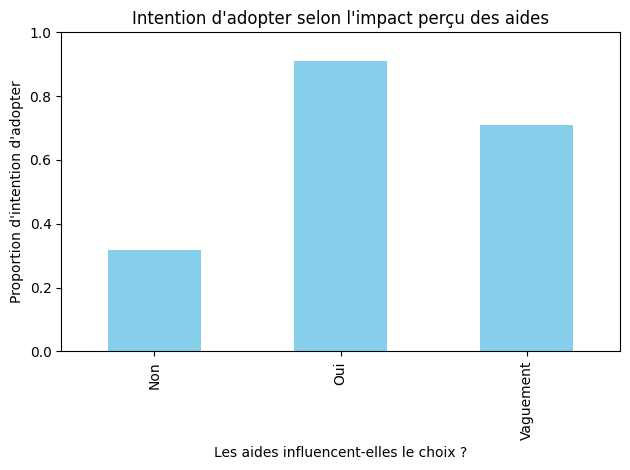

In [309]:
aides_col = "Connaissez-vous des aides financières disponibles pour l’achat d’un véhicule électrique ? (Cochez tout ce que vous connaissez)\n"

def count_aides(cell):
    if pd.isna(cell) or not cell.strip():
        return 0
    # Sépare sur la virgule, enlève les espaces, exclut "Aucune"
    return len([aide.strip() for aide in cell.split(',') if aide.strip() and aide.strip().lower() != "aucune"])

df['score_aides_connues'] = df[aides_col].apply(count_aides)
print(df['score_aides_connues'].describe())

# Impact perçu des aides
aide_influence_col = "Est-ce que ces aides impactent votre envie d'adopter un véhicule électrique ?"
aide_influence_by_aides = df.groupby('score_aides_connues')[aide_influence_col].value_counts(normalize=True).unstack().fillna(0)
# Moyenne de l'intention d'adopter selon l'impact perçu des aides
aide_influence_col = "Est-ce que ces aides impactent votre envie d'adopter un véhicule électrique ?"
mean_intention = df.groupby(aide_influence_col)['intention_adopter'].mean()

# Graphique
mean_intention.plot(kind='bar', color='skyblue')
plt.ylabel("Proportion d'intention d'adopter")
plt.xlabel("Les aides influencent-elles le choix ?")
plt.title("Intention d'adopter selon l'impact perçu des aides")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [310]:
# Exemple sur quelques variables
features = ['cout_trop_cher', 'connait_aides', 'score_aides_connues']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_scaled)
df.loc[X.index, 'cluster'] = kmeans.labels_
print(df['cluster'].value_counts())
# Affiche la moyenne de chaque variable par cluster
print(df.groupby('cluster')[['cout_trop_cher', 'connait_aides', 'score_aides_connues']].mean())

# Affiche aussi le nombre de répondants par cluster
print(df['cluster'].value_counts())
print(df.groupby('cluster')['intention_adopter'].mean())

cluster
0.0    131
1.0     28
2.0     23
Name: count, dtype: int64
         cout_trop_cher  connait_aides  score_aides_connues
cluster                                                    
0.0            0.923664            1.0             1.358779
1.0            0.714286            0.0             0.000000
2.0            0.913043            1.0             4.913043
cluster
0.0    131
1.0     28
2.0     23
Name: count, dtype: int64
cluster
0.0    0.615385
1.0         NaN
2.0    0.411765
Name: intention_adopter, dtype: float64


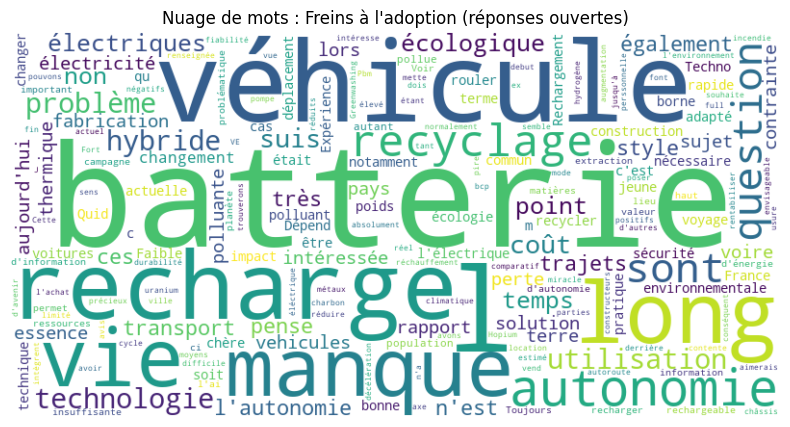

In [311]:
from wordcloud import WordCloud, STOPWORDS

# Liste de stopwords français de base
stopwords = set(STOPWORDS)
# Ajoute des mots spécifiques si besoin
stopwords.update([
    "les","je", "des", "aux", "avec", "pour", "dans", "sur", "par", "que", "qui", "une", "du", "en", "et", "le", "la", "un", "au", "ce", "se", "ne", "pas", "plus", "ou", "mais", "est", "à", "de", "il", "elle", "vous", "nous", "ils", "elles", "moi", "toi", "lui", "eux", "soi", "y", "en", "tout", "tous", "toutes", "bien", "mal", "comme", "si", "aussi", "sans", "sous", "avant", "après"
    "lors", "entre", "parce", "que", "quoi", "comment", "où", "quand", "pourquoi", "qui", "quel", "quelle", "lesquels", "lesquelles", "celui", "celle", "ceux", "celles", "cela", "ça", "ceci", "cela", "là", "ici", "là-bas", "ailleurs", "telle", "tellement", "tel", "tels", "telles", "tellement"
    "toute", "toutes", "tout", "tous", "chaque", "aucun", "aucune", "nul", "nulle", "rien", "personne", "quelqu'un", "quelque chose", "certains", "certaines", "plusieurs", "beaucoup", "trop", "assez", "peu", "moins","mon", "ton", "son", "notre", "votre", "leur", "ma", "ta", "sa", "mes", "tes", "ses", "nos", "vos", "leurs", "lui-même", "elle-même", "eux-mêmes", "elles-mêmes","électrique","encore","faire","voiture","plutôt","aussi","même","autre","autres","tous","toutes","quelque","quelques","quelques-uns","quelques-unes","certains","certaines","car","d","donc","alors","ainsi","tandis","pendant","lorsque","si","comme","parce que","puisque","bien que","quoique","malgré","sauf","excepté","au-delà de", "au lieu de", "à part", "en dehors de", "à l'exception de", "hormis", "sauf que", "excepté que", "mis à part", "sans compter que", "en plus de"
])

text = ' '.join(df["Pourquoi cette technologie ne vous intéresse pas ? Est-ce une question de valeurs, de style de vie, d'expériences ?\n"].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots : Freins à l'adoption (réponses ouvertes)")
plt.show()

---
# Psychological, Symbolic, and Identity-Based 

Diriez-vous que : [Vous êtes sensible aux questions environnementales]_clean
Totalement d'accord        113
Plutôt d'accord            106
Plutôt en désaccord          9
Totalement en désaccord      4
Name: count, dtype: int64


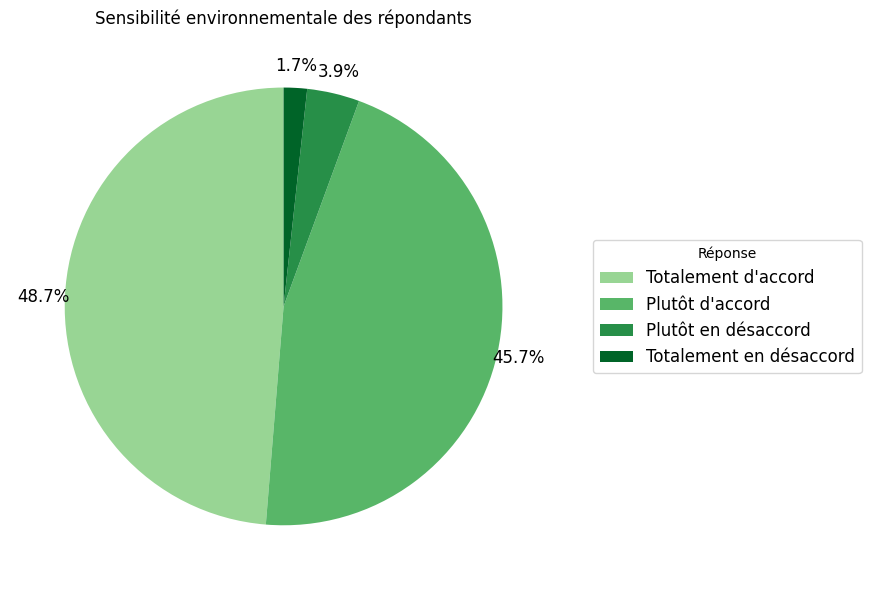

In [312]:
# Clean and normalize the responses
col_env = "Diriez-vous que : [Vous êtes sensible aux questions environnementales]"
df[col_env + "_clean"] = df[col_env].astype(str).str.strip().replace({
    "\nPlutôt en désaccord\n\n": "Plutôt en désaccord"
})

# Now count again
env_count_clean = df[col_env + "_clean"].value_counts(dropna=False)
print(env_count_clean)

# Pie chart sans labels sur le graphique
plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(
    env_count_clean.values,
    labels=None,  # Pas de labels sur le graphique
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Greens(np.linspace(0.4, 0.9, len(env_count_clean))),
    textprops={'fontsize': 12}
)
plt.title("Sensibilité environnementale des répondants")
plt.tight_layout()
plt.legend(wedges, env_count_clean.index, title="Réponse", bbox_to_anchor=(1.05, 0.5), loc="center left", fontsize=12)

# Décale les pourcentages pour éviter le chevauchement
for i, autotext in enumerate(autotexts):
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2
    x = 1.1 * np.cos(np.deg2rad(angle))
    y = 1.1 * np.sin(np.deg2rad(angle))
    autotext.set_position((x, y))

plt.show()


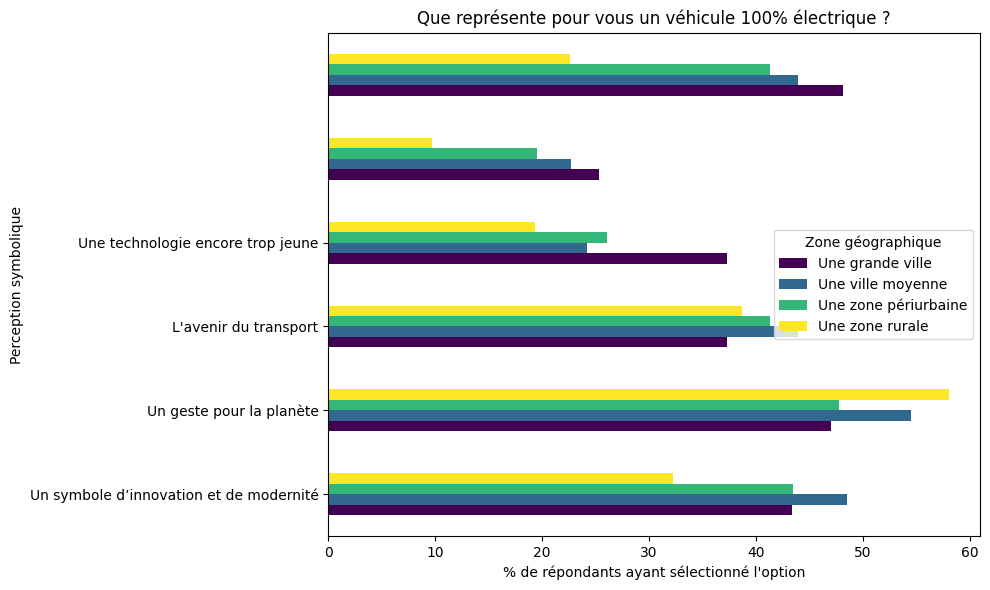

In [313]:
# Définition de symbolic_cols
symbolic_cols = [
    'Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)',
    'Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)',
    "Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)",
    'Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)',
]
# count pour 

labels, title = get_labels_and_title(symbolic_cols)

grouped_percent.plot(kind='barh', figsize=(10, 6), colormap='viridis')
plt.title(title)
plt.xlabel("% de répondants ayant sélectionné l'option")
plt.ylabel("Perception symbolique")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.legend(title="Zone géographique")
plt.tight_layout()
plt.show()


In [314]:
# Test statistique (exemple pour 'Un symbole d’innovation et de modernité')
from scipy.stats import chi2_contingency
ct_geo_modernity = pd.crosstab(df[geo_col], df[symbolic_cols[0]])
chi2, p, dof, _ = chi2_contingency(ct_geo_modernity)
print(f"Chi2: {chi2:.2f} | p-value: {p:.4f}")
if p < 0.05:
    print("✅ Différence significative selon l'origine géographique pour la perception 'modernité'.")
else:
    print("❌ Pas de différence significative selon l'origine géographique pour la perception 'modernité'.")

Chi2: 4.55 | p-value: 0.2083
❌ Pas de différence significative selon l'origine géographique pour la perception 'modernité'.


In [315]:
# Map age into numerical categories for simplicity
age_map = {
    "Moins de 25 ans": "18-24",
    "25 à 34 ans": "25-34",
    "35 à 44 ans": "35-44",
    "45 à 54 ans": "45-54",
    "55 à 64 ans": "55-64",
    "65 à 74 ans": "65-74",
    "75 ans et plus": "75+"
}
df['age_group'] = df["Dans quelle tranche d’âge vous situez-vous ?\n"].map(age_map)

# Example: symbol of modernity vs age
ct_modernity_age = pd.crosstab(df['age_group'],
    df['Que représente pour vous un véhicule entièrement électrique ? [Un symbole d’innovation et de modernité]'])

from scipy.stats import chi2_contingency

chi2, p, dof, _ = chi2_contingency(ct_modernity_age)
print(f"Chi2: {chi2:.2f} | p-value: {p:.4f}")

if p < 0.05:
    print("✅ Significant difference across age groups for 'modernity' perception.")
else:
    print("❌ No significant difference.")


Chi2: 5.07 | p-value: 0.2805
❌ No significant difference.


C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3815763089.py:19: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3815763089.py:19: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3815763089.py:19: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3815763089.py:19: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3815763089.py:19: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3815763089.py:19: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layo

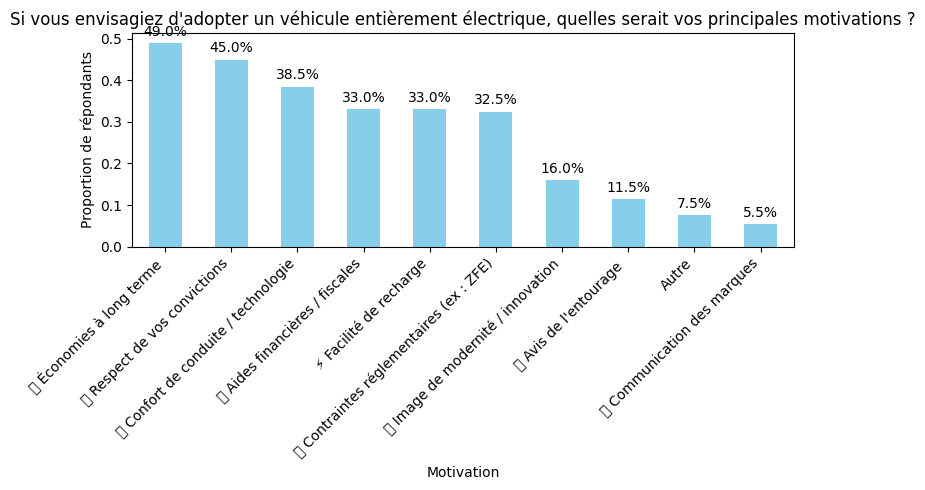

In [316]:
motivation_col = "Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? ("
motivation_cols = [col for col in df.columns if col.startswith(motivation_col)]
# Les colonnes motivation contiennent VRAI/FAUX, il faut donc les convertir en 0/1 avant de faire la moyenne
# On calcule ici la proportion de répondants ayant coché chaque motivation (mean = % de répondants ayant coché la case)
motivation_totals = df[motivation_cols].apply(
    lambda col: col.astype(str).str.strip().str.upper().map({'VRAI': 1, 'TRUE': 1, 'OUI': 1, '1': 1, 'FAUX': 0, 'FALSE': 0, 'NON': 0, '0': 0})
).mean().sort_values(ascending=False)


labels, title = get_labels_and_title(motivation_totals.index)
# Affiche les valeurs en pourcentage sur chaque barre
for i, v in enumerate(motivation_totals.values):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=10)
motivation_totals.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title(title)
plt.ylabel("Proportion de répondants")
plt.xlabel("Motivation")
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\416994244.py:19: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\416994244.py:19: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\416994244.py:19: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\416994244.py:19: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\416994244.py:19: UserWarning: Glyph 127873 (\N{WRAPPED PRESENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\416994244.py:19: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layou

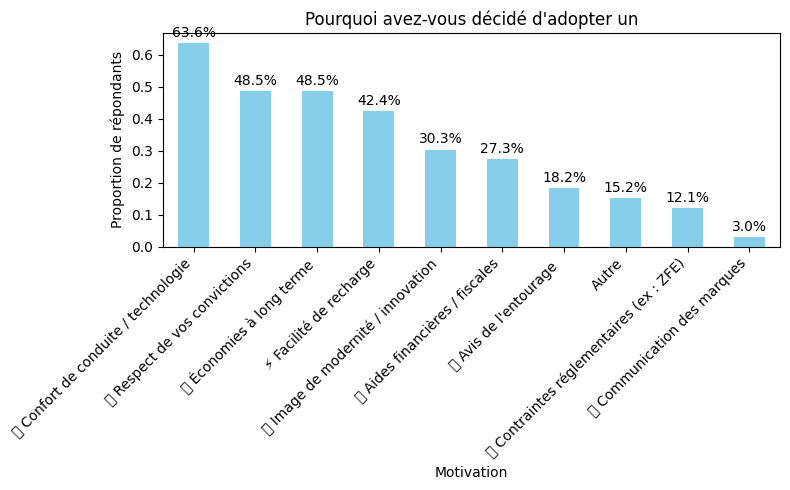

In [317]:
motivation_col = "Pourquoi avez-vous décidé d'adopter un \nvéhicule électrique, quelles ont été vos motivations ? ("
motivation_cols = [col for col in df.columns if col.startswith(motivation_col)]
# Les colonnes motivation contiennent VRAI/FAUX, il faut donc les convertir en 0/1 avant de faire la moyenne
# On calcule ici la proportion de répondants ayant coché chaque motivation (mean = % de répondants ayant coché la case)
motivation_totals = df[motivation_cols].apply(
    lambda col: col.astype(str).str.strip().str.upper().map({'VRAI': 1, 'TRUE': 1, 'OUI': 1, '1': 1, 'FAUX': 0, 'FALSE': 0, 'NON': 0, '0': 0})
).mean().sort_values(ascending=False)


labels, title = get_labels_and_title(motivation_totals.index)
# Affiche les valeurs en pourcentage sur chaque barre
for i, v in enumerate(motivation_totals.values):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=10)
motivation_totals.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title(title)
plt.ylabel("Proportion de répondants")
plt.xlabel("Motivation")
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3503059762.py:18: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3503059762.py:18: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3503059762.py:18: UserWarning: Glyph 128219 (\N{NAME BADGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3503059762.py:18: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3503059762.py:18: UserWarning: Glyph 128066 (\N{EAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3503059762.py:18: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu San

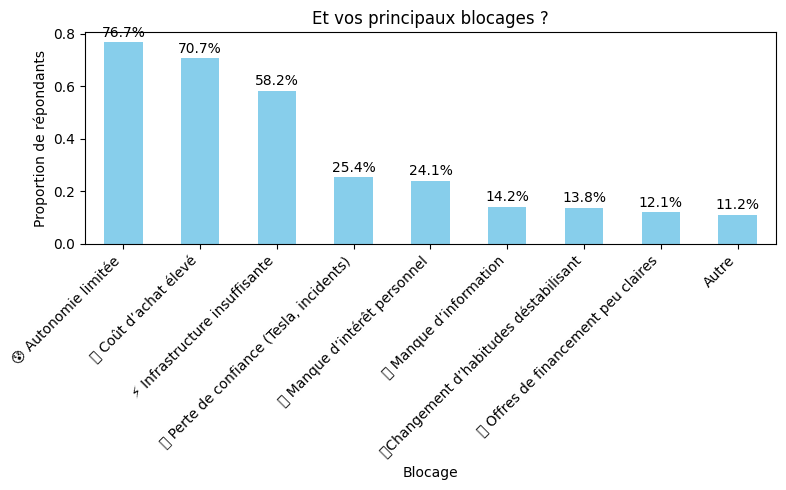

In [318]:
blocage_col = "Et vos principaux blocages ? ("
blocage_cols = [col for col in df.columns if col.startswith(blocage_col)]
# Les colonnes blocage contiennent VRAI/FAUX, il faut donc les convertir en 0/1 avant de faire la moyenne
# On calcule ici la proportion de répondants ayant coché chaque blocage (mean = % de répondants ayant coché la case)
blocage_totals = df[blocage_cols].apply(
    lambda col: col.astype(str).str.strip().str.upper().map({'VRAI': 1, 'TRUE': 1, 'OUI': 1, '1': 1, 'FAUX': 0, 'FALSE': 0, 'NON': 0, '0': 0})
).mean().sort_values(ascending=False)

labels, title = get_labels_and_title(blocage_totals.index)
# Affiche les valeurs en pourcentage sur chaque barre
for i, v in enumerate(blocage_totals.values):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=10)
blocage_totals.plot(kind='bar', color='skyblue', figsize=(8,5))
plt.title(title)
plt.ylabel("Proportion de répondants")
plt.xlabel("Blocage")
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [319]:
lifestyle_fit = df["Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"]
easy_to_use = df["Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]"]

# Frequency tables
print("Lifestyle fit:")
print(lifestyle_fit.value_counts())

print("\nEase of use:")
print(easy_to_use.value_counts())


Lifestyle fit:
Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]
Plutôt d'accord            72
Plutôt en désaccord        68
Totalement en désaccord    39
Tout à fait d'accord       20
Name: count, dtype: int64

Ease of use:
Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]
Plutôt d'accord            113
Tout à fait d'accord        68
Plutôt en désaccord         16
Totalement en désaccord      2
Name: count, dtype: int64


In [320]:
# Recode agreement into numerical score
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 4,
    "Totalement d'accord": 5
}

df['lifestyle_score'] = df["Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"].map(likert_map)
df['ev_owner'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"].fillna(False).astype(int)

# Logistic regression
import statsmodels.formula.api as smf

model_df = df[['ev_owner', 'lifestyle_score']].dropna()

# Check for constant columns or perfect separation
print("ev_owner value counts:\n", model_df['ev_owner'].value_counts())
print("lifestyle_score value counts:\n", model_df['lifestyle_score'].value_counts())

if model_df['ev_owner'].nunique() < 2 or model_df['lifestyle_score'].nunique() < 2:
    print("Not enough variation in variables for logistic regression.")
else:
    try:
        logit_model = smf.logit("ev_owner ~ lifestyle_score", data=model_df).fit()
        print(logit_model.summary())
    except Exception as e:
        print("Logistic regression failed:", e)


ev_owner value counts:
 ev_owner
0    179
Name: count, dtype: int64
lifestyle_score value counts:
 lifestyle_score
4.0    72
2.0    68
1.0    39
Name: count, dtype: int64
Not enough variation in variables for logistic regression.


C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\3440638755.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ev_owner'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"].fillna(False).astype(int)


In [321]:
from scipy.stats import chi2_contingency

# Colonnes à analyser
symbolic_cols = [
    'Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)',
    'Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)',
    "Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)",
    'Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)',
]

# Nettoyage des valeurs : conversion VRAI/FAUX etc.
for col in symbolic_cols:
    df[col] = df[col].apply(lambda x: 1 if str(x).strip().upper() in ['VRAI', 'TRUE', 'OUI', '1'] else
                                     0 if str(x).strip().upper() in ['FAUX', 'FALSE', 'NON', '0'] else np.nan)

# Tranche d'âge
age_col = "Dans quelle tranche d’âge vous situez-vous ?\n"

# Test de Chi2 pour chaque perception symbolique
for col in symbolic_cols:
    print(f"\n🔍 {col}")
    crosstab = pd.crosstab(df[age_col], df[col])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}")
    if p < 0.05:
        print("✅ Différence significative selon l'âge.")
    else:
        print("❌ Pas de différence significative.")



🔍 Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)
Chi2: 2.74, p-value: 0.9083
❌ Pas de différence significative.

🔍 Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)
Chi2: 12.66, p-value: 0.0809
❌ Pas de différence significative.

🔍 Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)
Chi2: 5.56, p-value: 0.5920
❌ Pas de différence significative.

🔍 Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)
Chi2: 6.60, p-value: 0.4717
❌ Pas de différence significative.


In [322]:
from scipy.stats import ttest_ind

# Variable cible
adoption_col = "Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"

# Nettoyage réponse binaire : 1 = favorable, 0 = non favorable
df["binary_adoption"] = df[adoption_col].apply(lambda x: 1 if "d'accord" in str(x).lower() else 0 if "désaccord" in str(x).lower() else np.nan)

# T-test entre les groupes : perçoivent le VE comme innovant vs pas
for col in symbolic_cols:
    group1 = df[df[col] == 1]["binary_adoption"].dropna()
    group0 = df[df[col] == 0]["binary_adoption"].dropna()
    tstat, p = ttest_ind(group1, group0, equal_var=False)
    print(f"\n🎯 Perception: {col}")
    print(f"T-stat: {tstat:.2f}, p-value: {p:.6f}")
    if p < 0.05:
        print("✅ Perception liée à une plus forte intention d’adoption.")
    else:
        print("❌ Pas de lien significatif.")



🎯 Perception: Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)
T-stat: 1.72, p-value: 0.089817
❌ Pas de lien significatif.

🎯 Perception: Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)
T-stat: 5.09, p-value: 0.000001
✅ Perception liée à une plus forte intention d’adoption.

🎯 Perception: Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)
T-stat: 5.35, p-value: 0.000001
✅ Perception liée à une plus forte intention d’adoption.

🎯 Perception: Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)
T-stat: -5.23, p-value: 0.000000
✅ Perception liée à une plus forte intention d’adoption.


In [323]:
# Colonne CSP
csp_col = "Quelle est votre situation professionnelle actuelle ?\n"

# Crosstab et test pour chaque perception
for col in symbolic_cols:
    print(f"\n🧪 {col}")
    crosstab = pd.crosstab(df[csp_col], df[col])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}")
    if p < 0.05:
        print("✅ Différence significative selon la catégorie professionnelle.")
    else:
        print("❌ Pas de différence significative.")



🧪 Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)
Chi2: 2.17, p-value: 0.9753
❌ Pas de différence significative.

🧪 Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)
Chi2: 12.05, p-value: 0.1491
❌ Pas de différence significative.

🧪 Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)
Chi2: 10.88, p-value: 0.2089
❌ Pas de différence significative.

🧪 Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)
Chi2: 7.94, p-value: 0.4397
❌ Pas de différence significative.


In [324]:
# Création de 4 groupes selon la combinaison de 2 perceptions
df['eco'] = df[symbolic_cols[1]]  # Geste pour la planète
df['modern'] = df[symbolic_cols[0]]  # Symbole d’innovation

df['symbolic_profile'] = df['eco'].astype(str) + "-" + df['modern'].astype(str)

# Moyenne d’intention d’adopter selon les profils combinés (utilise la variable numérique)
adoption_means = df.groupby('symbolic_profile')['intention_adopter'].mean()
print("\n📊 Taux moyen d’intention d’adopter par profil symbolique combiné :")
print(adoption_means)



📊 Taux moyen d’intention d’adopter par profil symbolique combiné :
symbolic_profile
0.0-0.0    0.360656
0.0-1.0    0.600000
1.0-0.0    0.791667
1.0-1.0    0.800000
nan-nan    0.250000
Name: intention_adopter, dtype: float64


In [325]:
# Colonnes concernées
polemic_col = "Diriez-vous que : [Les polémiques autour des VE vous inquiètent]"
repurchase_col = "Diriez-vous que : [En tant qu'utilisateur d'un véhicule électrique, vous en reprendrez un lors de votre prochain changement de véhicule]"
# Mapping commun à toutes les colonnes concernées
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Totalement d'accord": 4
    # Tu peux aussi ajouter "Je ne sais pas": np.nan si pertinent
}

df['polemic_score'] = df[polemic_col].map(likert_map)
df['repurchase_score'] = df[repurchase_col].map(likert_map)
# Suppose que c'est la colonne de type: '... (Électrique)'
# Corrélation polémiques <-> intention d’adopter (non-VE)
mask_non_ev = df['owns_ev'] == False
corr1 = df.loc[mask_non_ev, ['polemic_score', 'intention_adopter']].dropna()
if not corr1.empty:
    corr_val1 = corr1['polemic_score'].corr(corr1['intention_adopter'], method='pearson')
    print(f"Corrélation (polémiques vs intention d'adopter, non-VE): r = {corr_val1:.2f}")
else:
    print("Pas de données suffisantes pour la corrélation polémiques/intention (non-VE)")

# Corrélation polémiques <-> intention de racheter (VE owners)
mask_ev = df['owns_ev'] == True
corr2 = df.loc[mask_ev, ['polemic_score', 'repurchase_score']].dropna()
if not corr2.empty:
    corr_val2 = corr2['polemic_score'].corr(corr2['repurchase_score'], method='pearson')
    print(f"Corrélation (polémiques vs intention de reprendre un VE, propriétaires VE): r = {corr_val2:.2f}")
else:
    print("Pas de données suffisantes pour la corrélation polémiques/reprise VE (propriétaires VE)")


Corrélation (polémiques vs intention d'adopter, non-VE): r = 0.02
Corrélation (polémiques vs intention de reprendre un VE, propriétaires VE): r = -0.29


----
# D.	The technology, driving experience and its influence on the adoption

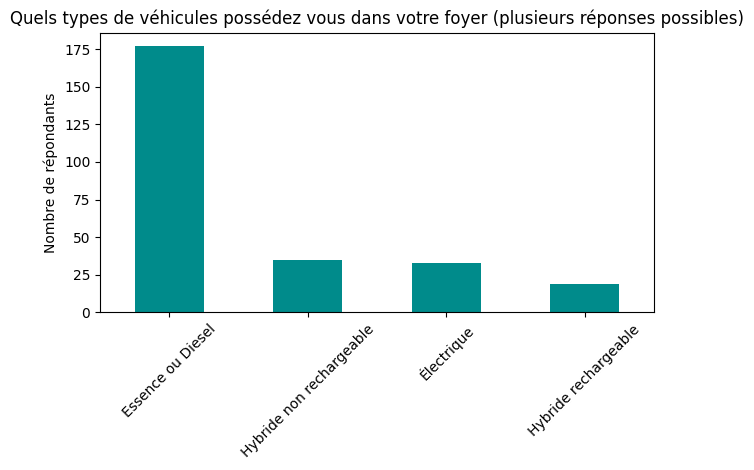

In [326]:
vehicle_cols = [
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Essence ou Diesel)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride non rechargeable)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride rechargeable)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)',
]



vehicle_counts = df[vehicle_cols].sum().sort_values(ascending=False)

labels, title = get_labels_and_title(vehicle_counts.index)

vehicle_counts.plot(kind='bar', color='darkcyan')
plt.title(title)
plt.ylabel("Nombre de répondants")
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.tight_layout()
plt.show()


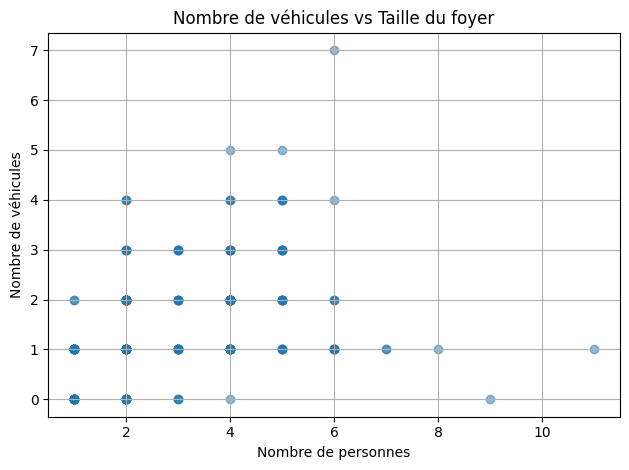

In [327]:
df['nb_vehicules'] = pd.to_numeric(df['Combien de véhicules personnels utilisez-vous dans votre foyer ?'], errors='coerce')
df['nb_personnes'] = pd.to_numeric(df['Combien êtes-vous dans votre foyer ?'], errors='coerce')

plt.scatter(df['nb_personnes'], df['nb_vehicules'], alpha=0.5)
plt.title("Nombre de véhicules vs Taille du foyer")
plt.xlabel("Nombre de personnes")
plt.ylabel("Nombre de véhicules")
plt.grid(True)
plt.tight_layout()
plt.show()


Nombre de répondants possédant un VE : 33
Nombre de possesseurs de VE ayant aussi un autre véhicule (thermique ou hybride) : 26
Proportion : 78.79%


C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\1830896098.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Essence ou Diesel)"].fillna(False).astype(bool) |
C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\1830896098.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride non rechargeable)"].fillna(False).astype(bool) |
C:\Users\Mango\AppData\Local\Temp\ipy

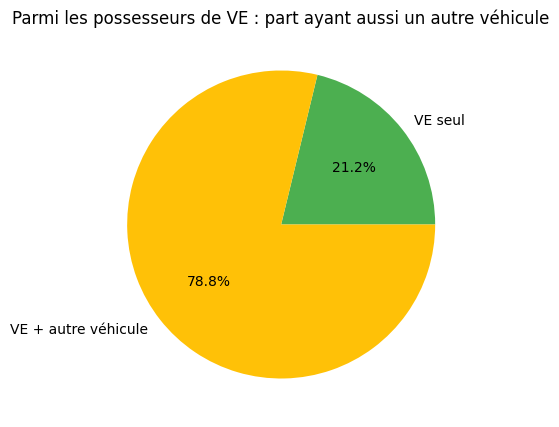

In [328]:
# Analyse : Les possesseurs de VE possèdent-ils souvent un autre véhicule thermique ou hybride ?

# 1. Création d'un masque pour les possesseurs de VE
mask_ev = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

# 2. Pour ces répondants, regarde s'ils ont aussi coché un autre type (essence/diesel ou hybride)
df['autre_vehicule'] = (
    df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Essence ou Diesel)"].fillna(False).astype(bool) |
    df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride non rechargeable)"].fillna(False).astype(bool) |
    df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride rechargeable)"].fillna(False).astype(bool)
)

# 3. Statistiques descriptives
nb_ev = mask_ev.sum()
nb_ev_avec_autre = df.loc[mask_ev, 'autre_vehicule'].sum()
part_ev_avec_autre = nb_ev_avec_autre / nb_ev if nb_ev > 0 else np.nan

print(f"Nombre de répondants possédant un VE : {nb_ev}")
print(f"Nombre de possesseurs de VE ayant aussi un autre véhicule (thermique ou hybride) : {nb_ev_avec_autre}")
print(f"Proportion : {part_ev_avec_autre:.2%}")

# 4. Visualisation
labels = ['VE seul', 'VE + autre véhicule']
sizes = [
    nb_ev - nb_ev_avec_autre,
    nb_ev_avec_autre
]
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#FFC107'])
plt.title("Parmi les possesseurs de VE : part ayant aussi un autre véhicule")
plt.show()

Moyenne par groupe (Sans VE / Avec VE) :
         nb_personnes  nb_vehicules
owns_ev                            
Sans VE      3.070352      1.537688
Avec VE      3.242424      2.303030
Nombre moyen de véhicules par taille de foyer et présence d'un VE (après nettoyage) :
owns_ev          False     True 
nb_personnes                    
1             0.580645  1.000000
2             1.267857  1.833333
3             1.363636  2.666667
4             1.888889  2.100000
5             2.450000  2.800000
6             1.600000       NaN
7             1.000000       NaN
8             1.000000       NaN
9             0.000000       NaN


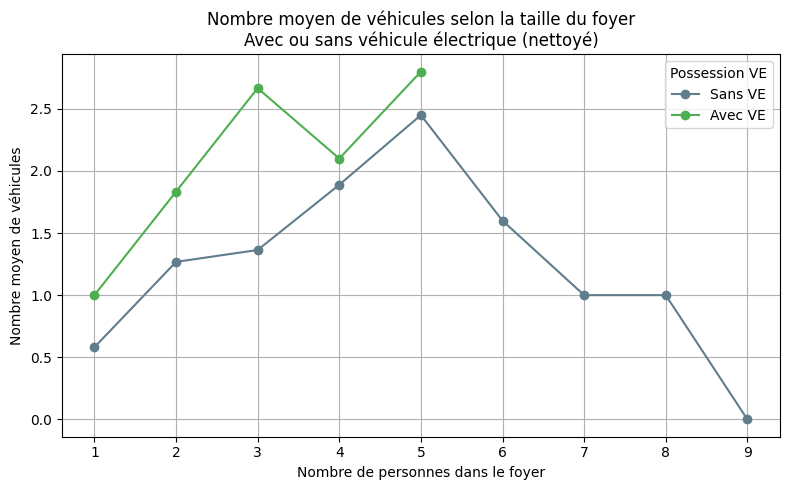

In [329]:

# Nettoyage des points aberrants pour nb_personnes et nb_vehicules
# Critères :
# - nb_personnes < 1 ou > 10
# - nb_vehicules < 0 ou > 10
# - nb_vehicules > nb_personnes

df_clean = df[
    (df['nb_personnes'].between(1, 10)) &
    (df['nb_vehicules'].between(0, 10)) &
    (df['nb_vehicules'] <= df['nb_personnes'])
].copy()

# Statistiques descriptives par groupe
stats = df.groupby('owns_ev')[['nb_personnes', 'nb_vehicules']].mean().rename(index={False: "Sans VE", True: "Avec VE"})
print("Moyenne par groupe (Sans VE / Avec VE) :")
print(stats)

# On regroupe par taille du foyer (nb_personnes) et possession d'un VE
pivot = df_clean.groupby(['nb_personnes', 'owns_ev'])['nb_vehicules'].mean().unstack()

print("Nombre moyen de véhicules par taille de foyer et présence d'un VE (après nettoyage) :")
print(pivot)

pivot.plot(kind='line', marker='o', figsize=(8,5), color=['#607d8b', '#4caf50'])
plt.title("Nombre moyen de véhicules selon la taille du foyer\nAvec ou sans véhicule électrique (nettoyé)")
plt.xlabel("Nombre de personnes dans le foyer")
plt.ylabel("Nombre moyen de véhicules")
plt.legend(["Sans VE", "Avec VE"], title="Possession VE")
plt.grid(True)
plt.tight_layout()
plt.show()

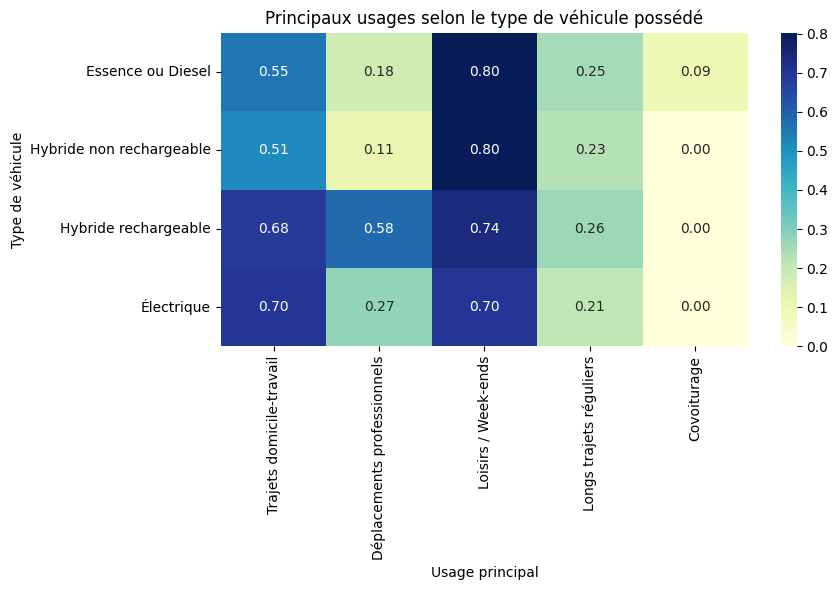

In [330]:
vehicle_types = {
    "Essence ou Diesel": [
        'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Essence ou Diesel)',
        'Quels sont les principaux usages de votre véhicule essence / diesel ? (Trajets domicile-travail)',
        'Quels sont les principaux usages de votre véhicule essence / diesel ? (Déplacements professionnels)',
        'Quels sont les principaux usages de votre véhicule essence / diesel ? (Loisirs / Week-ends)',
        'Quels sont les principaux usages de votre véhicule essence / diesel ? (Longs trajets réguliers)',
        'Quels sont les principaux usages de votre véhicule essence / diesel ? (Covoiturage)'
    ],
    "Hybride non rechargeable": [
        'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride non rechargeable)',
        'Quels sont les principaux usages de votre véhicule hybride non rechargeable ? (Trajets domicile-travail)',
        'Quels sont les principaux usages de votre véhicule hybride non rechargeable ? (Déplacements professionnels)',
        'Quels sont les principaux usages de votre véhicule hybride non rechargeable ? (Loisirs / Week-ends)',
        'Quels sont les principaux usages de votre véhicule hybride non rechargeable ? (Longs trajets réguliers)',
        'Quels sont les principaux usages de votre véhicule hybride non rechargeable ? (Covoiturage)'
    ],
    "Hybride rechargeable": [
        'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride rechargeable)',
        'Quels sont les principaux usages de votre véhicule hybride rechargeable ? (Trajets domicile-travail)',
        'Quels sont les principaux usages de votre véhicule hybride rechargeable ? (Déplacements professionnels)',
        'Quels sont les principaux usages de votre véhicule hybride rechargeable ? (Loisirs / Week-ends)',
        'Quels sont les principaux usages de votre véhicule hybride rechargeable ? (Longs trajets réguliers)',
        'Quels sont les principaux usages de votre véhicule hybride rechargeable ? (Covoiturage)'
    ],
    "Électrique": [
        'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)',
        "Quels sont lesprincipaux usages de votre véhicule électrique ? (Trajets domicile-travail)",
        "Quels sont lesprincipaux usages de votre véhicule électrique ? (Déplacements professionnels)",
        "Quels sont lesprincipaux usages de votre véhicule électrique ? (Loisirs / Week-ends)",
        "Quels sont lesprincipaux usages de votre véhicule électrique ? (Longs trajets réguliers)",
        "Quels sont lesprincipaux usages de votre véhicule électrique ? (Covoiturage)"
    ]
}

# Utilise la fonction pour obtenir les labels d'usages et le titre
usage_labels, title = get_labels_and_title([
    'Quels sont les principaux usages de votre véhicule essence / diesel ? (Trajets domicile-travail)',
    'Quels sont les principaux usages de votre véhicule essence / diesel ? (Déplacements professionnels)',
    'Quels sont les principaux usages de votre véhicule essence / diesel ? (Loisirs / Week-ends)',
    'Quels sont les principaux usages de votre véhicule essence / diesel ? (Longs trajets réguliers)',
    'Quels sont les principaux usages de votre véhicule essence / diesel ? (Covoiturage)'
])

usage_matrix = []
for vtype, cols in vehicle_types.items():
    owner_col = cols[0]
    usage_cols = cols[1:]
    mask = df[owner_col] == True
    if mask.sum() == 0:
        usage_matrix.append([np.nan]*len(usage_cols))
        continue
    means = df.loc[mask, usage_cols].mean().values
    usage_matrix.append(means)

usage_df = pd.DataFrame(usage_matrix, columns=usage_labels, index=list(vehicle_types.keys()))

plt.figure(figsize=(9,6))
sns.heatmap(usage_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Principaux usages selon le type de véhicule possédé")
plt.xlabel("Usage principal")
plt.ylabel("Type de véhicule")
plt.tight_layout()
plt.show()



In [331]:
from scipy.stats import pearsonr

# Assure que les colonnes existent et sont numériques
if 'nb_personnes' not in df.columns or 'nb_vehicules' not in df.columns:
    df['nb_vehicules'] = pd.to_numeric(df['Combien de véhicules personnels utilisez-vous dans votre foyer ?'], errors='coerce')
    df['nb_personnes'] = pd.to_numeric(df['Combien êtes-vous dans votre foyer ?'], errors='coerce')

# Retire les lignes où l'une des deux valeurs est manquante
valid = df[['nb_personnes', 'nb_vehicules']].dropna()
corr, pval = pearsonr(valid['nb_personnes'], valid['nb_vehicules'])
print(f"Corrélation personnes-véhicules : r = {corr:.2f}, p = {pval:.8f}")

if pval < 0.05:
    print("✅ Il existe une corrélation statistiquement significative entre le nombre de personnes et le nombre de véhicules dans le foyer.")
else:
    print("❌ Aucune corrélation significative détectée entre le nombre de personnes et le nombre de véhicules dans le foyer.")

Corrélation personnes-véhicules : r = 0.30, p = 0.00000340
✅ Il existe une corrélation statistiquement significative entre le nombre de personnes et le nombre de véhicules dans le foyer.


In [332]:
driving_exp_col = "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"

# Recodage échelle 4 points
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Tout à fait d'accord": 4,
    "Tout à fait d’accord": 4,  # gestion des accents différents
}

df[driving_exp_col + "_score"] = df[driving_exp_col].map(likert_map)

# Vérification du recodage
print(df[driving_exp_col].value_counts())
print(df[driving_exp_col + "_score"].value_counts())

# Utilisation pour les moyennes par type de véhicule
for col in vehicle_cols:
    avg = df[df[col] == True][driving_exp_col + "_score"].mean()
    print(f"{col.split('(')[-1][:-1]}: {avg:.2f}")

Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]
Plutôt d'accord            72
Plutôt en désaccord        68
Totalement en désaccord    39
Tout à fait d'accord       20
Name: count, dtype: int64
Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]_score
3.0    72
2.0    68
1.0    39
4.0    20
Name: count, dtype: int64
Essence ou Diesel: 2.30
Hybride non rechargeable: 2.41
Hybride rechargeable: 2.22
Électrique: nan


C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\2199579644.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['type_vehicule'] = df[vehicle_cols].idxmax(axis=1)


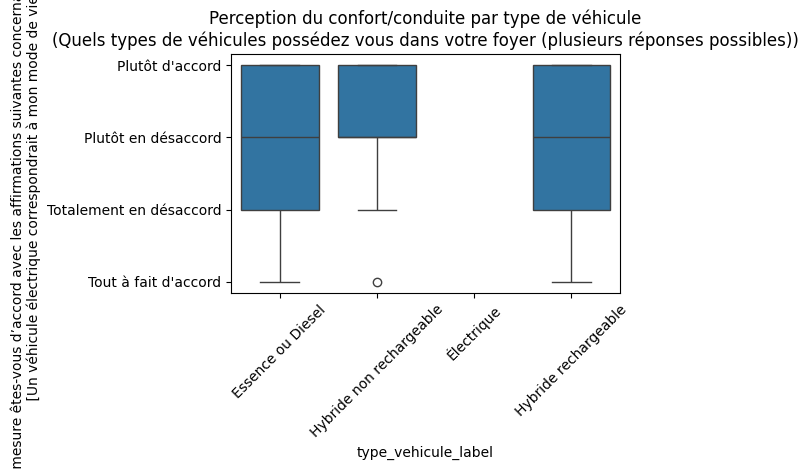

ANOVA: F = 0.29, p = 0.7462
❌ Pas de différence significative entre les types de véhicules pour la perception du confort/conduite.


In [333]:
labels, title = get_labels_and_title(vehicle_cols)
df['type_vehicule'] = df[vehicle_cols].idxmax(axis=1)
df['type_vehicule_label'] = df['type_vehicule'].map(dict(zip(vehicle_cols, labels)))

sns.boxplot(data=df, x='type_vehicule_label', y=driving_exp_col)
plt.title(f"Perception du confort/conduite par type de véhicule\n({title})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

from scipy.stats import f_oneway

# Utilise le score numérique pour l'ANOVA
groups = []
for col in vehicle_cols:
    vals = df.loc[df[col] == True, driving_exp_col + "_score"].dropna()
    if len(vals) >= 2:
        groups.append(vals)

if len(groups) >= 2:
    fval, pval = f_oneway(*groups)
    print(f"ANOVA: F = {fval:.2f}, p = {pval:.4f}")
    if pval < 0.05:
        print("✅ Différence significative entre les types de véhicules pour la perception du confort/conduite.")
    else:
        print("❌ Pas de différence significative entre les types de véhicules pour la perception du confort/conduite.")
else:
    print("Pas assez de données dans chaque groupe pour faire une ANOVA valide.")


Score moyen adoption pour ceux qui ne possèdent pas de VE :
2.3668341708542715
Score moyen intention de racheter pour ceux qui possèdent un VE :
3.2903225806451615


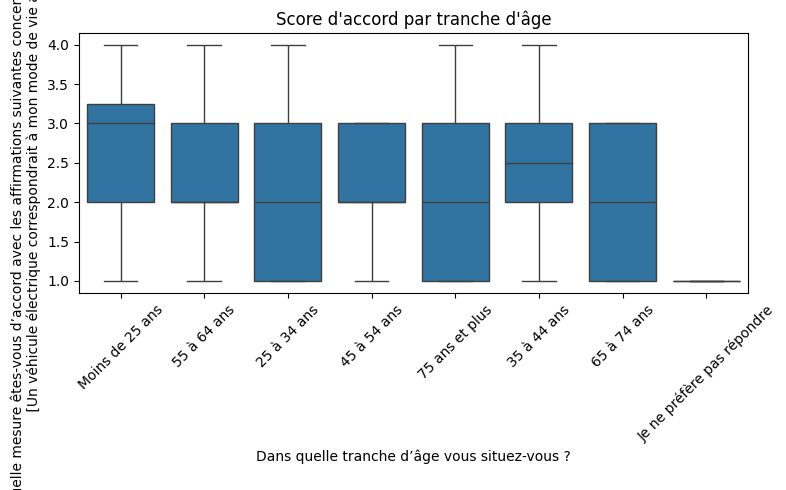

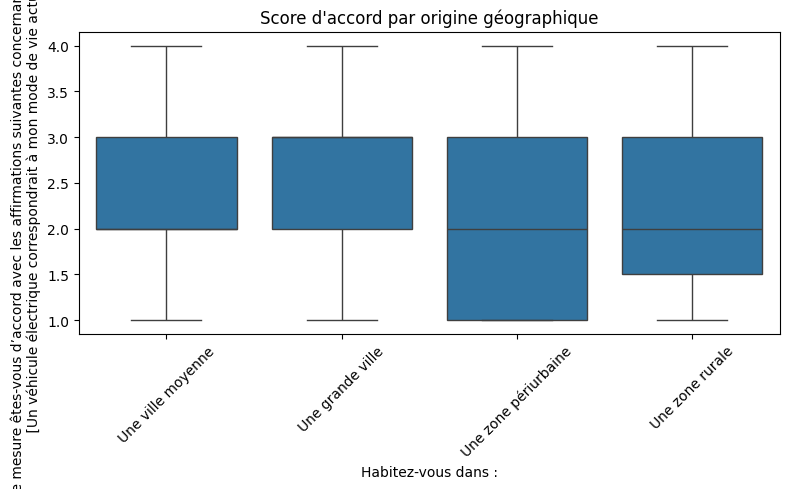

C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\2395256648.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores, labels=labels)


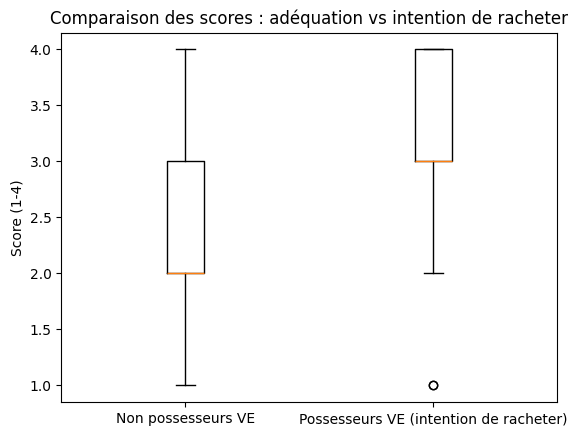

In [334]:
# 1. Score moyen selon la possession d'un VE
print("Score moyen adoption pour ceux qui ne possèdent pas de VE :")
print(df.loc[df['owns_ev'] == False, "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]_score"].mean())
print("Score moyen intention de racheter pour ceux qui possèdent un VE :")
print(df.loc[df['owns_ev'] == True, "repurchase_score"].mean())
# 2. Répartition du score par tranche d'âge
age_col = "Dans quelle tranche d’âge vous situez-vous ?\n"
score_col = "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]_score"
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x=age_col, y=score_col)
plt.title("Score d'accord par tranche d'âge")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Répartition du score par origine géographique
geo_col = "Habitez-vous dans :"
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x=geo_col, y=score_col)
plt.title("Score d'accord par origine géographique")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

scores = [
    df.loc[df['owns_ev'] == False, "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]_score"].dropna(),
    df.loc[df['owns_ev'] == True, "repurchase_score"].dropna()
]
labels = ["Non possesseurs VE", "Possesseurs VE (intention de racheter)"]

plt.boxplot(scores, labels=labels)
plt.ylabel("Score (1-4)")
plt.title("Comparaison des scores : adéquation vs intention de racheter")
plt.show()

In [335]:
from scipy.stats import f_oneway

# Test ANOVA : score d'accord selon la tranche d'âge
age_col = "Dans quelle tranche d’âge vous situez-vous ?\n"
score_col = "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]_score"

df_age = df[df[age_col] != "Je ne préfère pas répondre"]

# On crée une liste de groupes (un par tranche d'âge, sans NaN)
groups = [g[score_col].dropna() for _, g in df_age.groupby(age_col) if g[score_col].notna().sum() > 1]

if len(groups) >= 2:
    fval, pval = f_oneway(*groups)
    print(f"ANOVA score d'accord par âge : F = {fval:.2f}, p = {pval:.4f}")
    if pval < 0.05:
        print("✅ Différence significative entre les groupes d'âge.")
    else:
        print("❌ Pas de différence significative entre les groupes d'âge.")
else:
    print("Pas assez de groupes pour faire une ANOVA valide.")

# Test ANOVA : score d'accord selon l'origine géographique
geo_col = "Habitez-vous dans :"
groups_geo = [g[score_col].dropna() for _, g in df.groupby(geo_col) if g[score_col].notna().sum() > 1]

if len(groups_geo) >= 2:
    fval_geo, pval_geo = f_oneway(*groups_geo)
    print(f"ANOVA score d'accord par origine géographique : F = {fval_geo:.2f}, p = {pval_geo:.4f}")
    if pval_geo < 0.05:
        print("✅ Différence significative entre les zones géographiques.")
    else:
        print("❌ Pas de différence significative entre les zones géographiques.")
else:
    print("Pas assez de groupes pour faire une ANOVA valide (origine géographique).")
# Moyenne du score par âge
print(df.groupby(age_col)[score_col].mean())

# Moyenne du score par zone géographique
print(df.groupby(geo_col)[score_col].mean())


ANOVA score d'accord par âge : F = 4.45, p = 0.0003
✅ Différence significative entre les groupes d'âge.
ANOVA score d'accord par origine géographique : F = 2.97, p = 0.0330
✅ Différence significative entre les zones géographiques.
Dans quelle tranche d’âge vous situez-vous ?\n
25 à 34 ans                   2.178571
35 à 44 ans                   2.454545
45 à 54 ans                   2.105263
55 à 64 ans                   2.303030
65 à 74 ans                   2.050000
75 ans et plus                2.111111
Je ne préfère pas répondre    1.000000
Moins de 25 ans               2.895833
Name: Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]_score, dtype: float64
Habitez-vous dans :
Une grande ville        2.608108
Une ville moyenne       2.258621
Une zone périurbaine    2.150000
Une zone rurale         2.259259
Name: Dans quelle mesure êtes-vous d’accord avec les a

Expérience VE (déjà monté/conduit) :
exp_ev
2.0    70
3.0    68
1.0    33
Name: count, dtype: int64

Score moyen de connaissance selon expérience :
exp_ev
1.0    1.818182
2.0    2.071429
3.0    2.411765
Name: connaissance_score, dtype: float64

Intention d'adopter selon expérience :
exp_ev
1.0    0.428571
2.0    0.500000
3.0    0.648148
Name: intention_adopter, dtype: float64

Comparaison du score de connaissance :
  - Moyenne sans expérience VE : 1.82 (n=33)
  - Moyenne avec expérience VE : 2.24 (n=138)
  - T-test : t = 2.62, p-value = 0.0115

Comparaison de l'intention d'adopter :
  - Moyenne sans expérience VE : 0.43 (n=21)
  - Moyenne avec expérience VE : 0.57 (n=108)
  - T-test : t = 1.21, p-value = 0.2375

Analyse des résultats :
- Les personnes ayant déjà conduit ou été passager d'un VE ont un score de connaissance significativement plus élevé que celles sans expérience.
- L'expérience avec un VE n'est pas associée à une différence significative d'intention d'adopter dans cet éc

<Figure size 600x400 with 0 Axes>

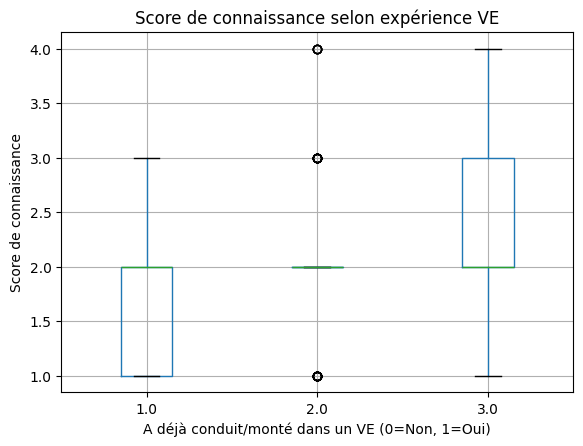

In [336]:
# 1. Nettoyage des variables
exp_col = "Avez-vous déjà eu l’occasion de conduire ou de monter dans un véhicule électrique ?"
connaissance_col = "À quel point diriez-vous que vous connaissez bien les offres actuelles de véhicules électriques et d'infrastructures associées ?"

# Recodage expérience : 1 = Oui, 0 = Non
df['exp_ev'] = df[exp_col].map({'Oui, j’ai conduit': 3,'Oui, j’étais passager': 2,'Non, jamais': 1})

# Recodage connaissance : suppose une échelle 1-5 ou texte, à adapter si besoin
# Si c'est déjà numérique, pas besoin de map
connaissance_map = {
        "Pas du tout, je ne m’y suis jamais vraiment intéressé": 1,
        "Un peu, je connais quelques modèles et options": 2,
        "Assez bien, je vois passer des informations": 3,
        "Très bien, je suis régulièrement les nouveautés": 4
    }
df['connaissance_score'] = df[connaissance_col].map(connaissance_map)

# 2. Statistiques descriptives
print("Expérience VE (déjà monté/conduit) :")
print(df['exp_ev'].value_counts(dropna=True))
print("\nScore moyen de connaissance selon expérience :")
print(df.groupby('exp_ev')['connaissance_score'].mean())
print("\nIntention d'adopter selon expérience :")
print(df.groupby('exp_ev')['intention_adopter'].mean())



# 3. Test statistique : expérience vs connaissance (t-test)
from scipy.stats import ttest_ind
group_noexp = df[df['exp_ev'] == 1]['connaissance_score'].dropna()
group_exp = df[df['exp_ev'] > 1]['connaissance_score'].dropna()
tstat, pval = ttest_ind(group_exp, group_noexp, equal_var=False)
print(f"\nComparaison du score de connaissance :")
print(f"  - Moyenne sans expérience VE : {group_noexp.mean():.2f} (n={len(group_noexp)})")
print(f"  - Moyenne avec expérience VE : {group_exp.mean():.2f} (n={len(group_exp)})")
print(f"  - T-test : t = {tstat:.2f}, p-value = {pval:.4f}")

# 4. Test statistique : expérience vs intention d'adopter (t-test)
group_noexp2 = df[df['exp_ev'] == 1]['intention_adopter'].dropna()
group_exp2 = df[df['exp_ev'] > 1]['intention_adopter'].dropna()
tstat2, pval2 = ttest_ind(group_exp2, group_noexp2, equal_var=False)
print(f"\nComparaison de l'intention d'adopter :")
print(f"  - Moyenne sans expérience VE : {group_noexp2.mean():.2f} (n={len(group_noexp2)})")
print(f"  - Moyenne avec expérience VE : {group_exp2.mean():.2f} (n={len(group_exp2)})")
print(f"  - T-test : t = {tstat2:.2f}, p-value = {pval2:.4f}")

# Analyse des résultats
print("\nAnalyse des résultats :")
if pval < 0.05:
    print("- Les personnes ayant déjà conduit ou été passager d'un VE ont un score de connaissance significativement plus élevé que celles sans expérience.")
else:
    print("- Aucune différence significative de connaissance entre les groupes selon l'expérience VE.")

if pval2 < 0.05:
    print("- L'expérience avec un VE est associée à une intention d'adopter significativement plus forte.")
else:
    print("- L'expérience avec un VE n'est pas associée à une différence significative d'intention d'adopter dans cet échantillon.")

# 5. Visualisation
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
df.boxplot(column='connaissance_score', by='exp_ev')
plt.title("Score de connaissance selon expérience VE")
plt.suptitle("")
plt.xlabel("A déjà conduit/monté dans un VE (0=Non, 1=Oui)")
plt.ylabel("Score de connaissance")
plt.show()




Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [La durabilité d'un véhicule électrique est équivalente à celle d'un véhicule thermique]
Plutôt en désaccord        94
Plutôt d'accord            50
Totalement en désaccord    37
NaN                        33
Tout à fait d'accord       18
Name: count, dtype: int64


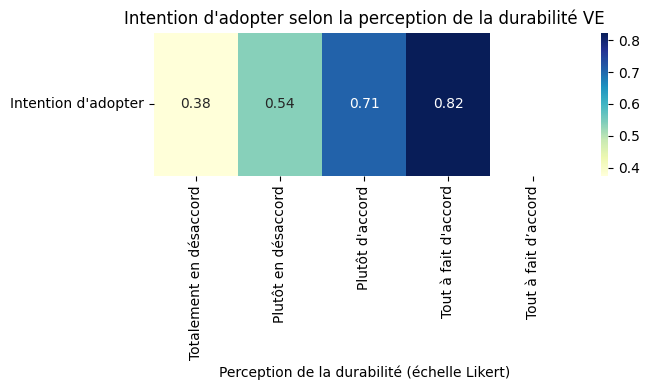

Corrélation score durabilité <-> intention d'adopter : r = 0.29, p = 0.0003
✅ La perception de la durabilité est significativement liée à l'intention d'adopter.

Tableau croisé possession VE x perception durabilité :
Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?
 [La durabilité d'un véhicule électrique est équivalente à celle d'un véhicule thermique]  Plutôt d'accord  \
owns_ev                                                                                                                                                                                                                   
False                                                                                                                                                                                                                50   

Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?
 [La durabilité 

In [337]:
import seaborn as sns
from scipy.stats import pearsonr

# Analyse de la perception de la durabilité VE vs thermique

durability_col = "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [La durabilité d'un véhicule électrique est équivalente à celle d'un véhicule thermique]"

# 1. Distribution des réponses
print(df[durability_col].value_counts(dropna=False))

# 2. Croisement avec intention d'adopter
if 'intention_adopter' in df.columns:
    import matplotlib.pyplot as plt
    # Un boxplot n'est pas très informatif ici car la variable 'intention_adopter' est binaire (0/1).
    # Une heatmap ou un barplot des moyennes par modalité de perception serait plus lisible.

    # Calcul de la moyenne d'intention d'adopter par modalité de perception de la durabilité
    mean_intention_by_durability = df.groupby(durability_col)['intention_adopter'].mean().reindex([
        "Totalement en désaccord", "Plutôt en désaccord", "Plutôt d'accord", "Tout à fait d'accord", "Tout à fait d’accord"
    ])
    plt.figure(figsize=(7,4))
    sns.heatmap(mean_intention_by_durability.values.reshape(1, -1), annot=True, fmt=".2f",
                xticklabels=mean_intention_by_durability.index, yticklabels=["Intention d'adopter"], cmap="YlGnBu")
    plt.title("Intention d'adopter selon la perception de la durabilité VE")
    plt.xlabel("Perception de la durabilité (échelle Likert)")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Test statistique (ANOVA si Likert numérique)
    # Recodage si besoin
    df['durability_score'] = df[durability_col].map(likert_map)
    valid = df[['durability_score', 'intention_adopter']].dropna()
    if not valid.empty:
        r, p = pearsonr(valid['durability_score'], valid['intention_adopter'])
        print(f"Corrélation score durabilité <-> intention d'adopter : r = {r:.2f}, p = {p:.4f}")
        if p < 0.05:
            print("✅ La perception de la durabilité est significativement liée à l'intention d'adopter.")
        else:
            print("❌ Pas de lien significatif entre perception de la durabilité et intention d'adopter.")

# 3. Croisement avec la possession d'un VE
if 'owns_ev' in df.columns:
    ct = pd.crosstab(df['owns_ev'], df[durability_col])
    print("\nTableau croisé possession VE x perception durabilité :")
    print(ct)

----
# E.	Charging Infrastructure

Habitez-vous dans :
Une grande ville        84
Une ville moyenne       70
Une zone périurbaine    47
Une zone rurale         31
Name: count, dtype: int64
Avez-vous accès à une place de parking personnelle ?
Oui, avec borne de recharge ou possibilité d'en installer une (à domicile ou en résidence par exemple)    99
Oui, sans borne de recharge ou possibilité d'en installer une                                             82
Non                                                                                                       51
Name: count, dtype: int64
Fréquence de chaque type de borne connue :
Oui: 274
des bornes "privées" (Supermarché: 119
lieu de travail...): 119
des bornes publiques: 110
Non: 55
je n'en vois pas: 55
à domicile (maison: 45
résidence...): 45
borne_type                 Non       Oui  des bornes "privées" (Supermarché  \
Habitez-vous dans :                                                           
Une grande ville      0.077441  0.323232                           0.1

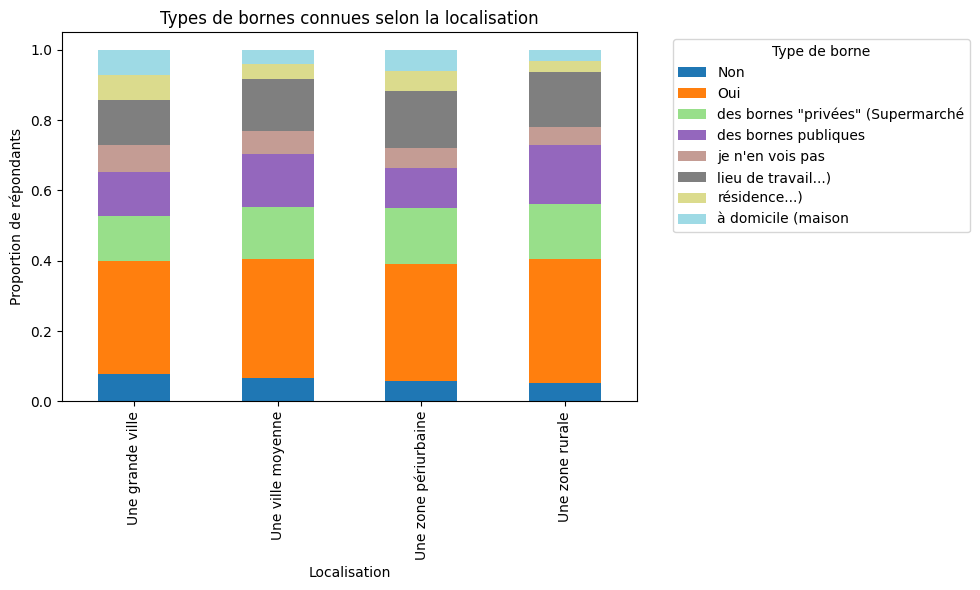

Test du Chi² localisation vs connaissance de bornes : p-value = 0.3993
Test du Chi² localisation vs connaissance de bornes : p-value = 0.3993

--- Analyse automatique ---
❌ Aucune différence significative détectée entre les zones pour la connaissance des types de bornes.

Tendances globales :
- 'Non' : en moyenne 6.4% des répondants la citent, toutes zones confondues.
- 'Oui' : en moyenne 33.7% des répondants la citent, toutes zones confondues.
- 'des bornes "privées" (Supermarché' : en moyenne 14.8% des répondants la citent, toutes zones confondues.
- 'des bornes publiques' : en moyenne 13.8% des répondants la citent, toutes zones confondues.
- 'je n'en vois pas' : en moyenne 6.4% des répondants la citent, toutes zones confondues.
- 'lieu de travail...)' : en moyenne 14.8% des répondants la citent, toutes zones confondues.
- 'résidence...)' : en moyenne 5.1% des répondants la citent, toutes zones confondues.
- 'à domicile (maison' : en moyenne 5.1% des répondants la citent, toutes zon

In [356]:
# 1.1 Répartition des répondants par type de localisation
print(df['Habitez-vous dans :'].value_counts(dropna=False))

# 1.2 Accès à une place de parking personnelle
print(df['Avez-vous accès à une place de parking personnelle ?'].value_counts(dropna=False))

# 1.3 Connaissance de bornes accessibles près de chez soi
# Si les réponses sont séparées par des virgules, on "explose" la colonne en plusieurs valeurs
bornes_accessibles_col = 'Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'

# On s'assure que la colonne est bien une chaîne de caractères
df[bornes_accessibles_col] = df[bornes_accessibles_col].astype(str)

# On sépare les réponses multiples et on les met à plat
from collections import Counter

all_answers_bornes_accessibles = df[bornes_accessibles_col].dropna().apply(lambda x: [ans.strip() for ans in x.split(',') if ans.strip() and ans.lower() != 'nan'])
flat_answers_bornes_accessibles = [item for sublist in all_answers for item in sublist]

# Compte la fréquence de chaque réponse
answer_counts = Counter(flat_answers_bornes_accessibles)
print("Fréquence de chaque type de borne connue :")
for k, v in answer_counts.most_common():
    print(f"{k}: {v}")

# ...existing code...

col_loc = 'Habitez-vous dans :'
col_bornes = 'Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'

# On s'assure que la colonne est bien une chaîne de caractères
df[col_bornes] = df[col_bornes].astype(str)

# On crée un DataFrame "explosé" : une ligne par type de borne connue
df_exploded = df.assign(
    borne_type=df[col_bornes].str.split(',')
).explode('borne_type')
df_exploded['borne_type'] = df_exploded['borne_type'].str.strip()
df_exploded = df_exploded[df_exploded['borne_type'].notna() & (df_exploded['borne_type'] != '')]

# Tableau croisé
crosstab = pd.crosstab(df_exploded[col_loc], df_exploded['borne_type'], normalize='index')

print(crosstab)

crosstab.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("Types de bornes connues selon la localisation")
plt.ylabel("Proportion de répondants")
plt.xlabel("Localisation")
plt.legend(title="Type de borne", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 1.5 Test du Chi² localisation vs connaissance de bornes
ct = pd.crosstab(df['Habitez-vous dans :'], df['Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?'])
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Test du Chi² localisation vs connaissance de bornes : p-value = {p:.4f}")
# ...existing code...
print(f"Test du Chi² localisation vs connaissance de bornes : p-value = {p:.4f}")

# Analyse automatique des résultats
print("\n--- Analyse automatique ---")
if p < 0.05:
    print("✅ Il existe une différence significative dans la connaissance des types de bornes selon la localisation des répondants.")
    # Exemple d'analyse simple : repérer les bornes les plus connues par zone
    for loc in crosstab.index:
        top_borne = crosstab.loc[loc].idxmax()
        top_val = crosstab.loc[loc].max()
        print(f"- Dans '{loc}', la borne la plus souvent citée est : '{top_borne}' ({top_val:.1%} des répondants de cette zone)")
else:
    print("❌ Aucune différence significative détectée entre les zones pour la connaissance des types de bornes.")

# Aperçu des tendances globales
print("\nTendances globales :")
for borne in crosstab.columns:
    mean_val = crosstab[borne].mean()
    print(f"- '{borne}' : en moyenne {mean_val:.1%} des répondants la citent, toutes zones confondues.")

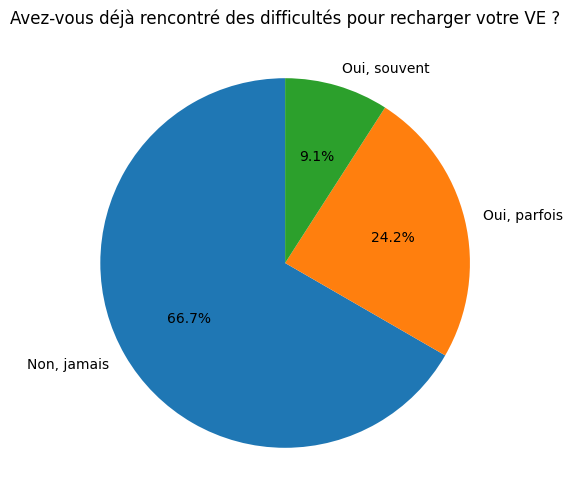

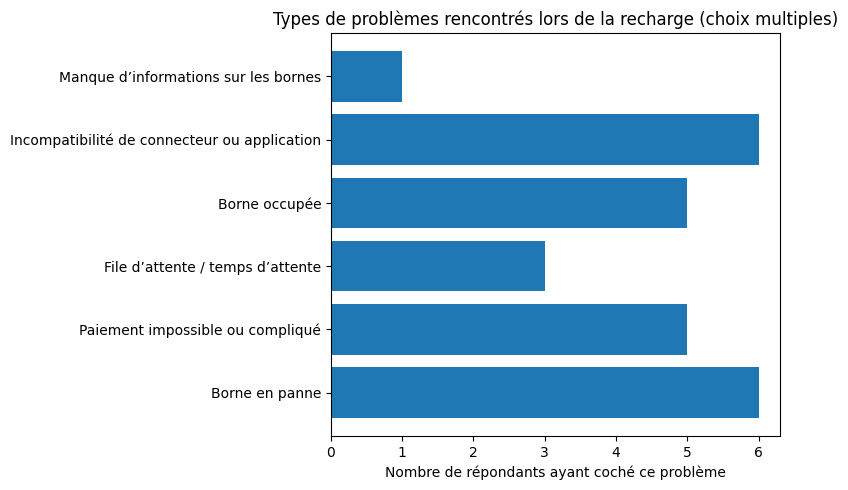

In [339]:
import matplotlib.pyplot as plt
import numpy as np

col_pb = "Avez-vous déjà rencontré des difficultés pour recharger votre véhicule électrique ?\n"
pb_cols = [
    'Quels types de problèmes rencontrez-vous ? (Borne en panne)',
    'Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)',
    'Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)',
    'Quels types de problèmes rencontrez-vous ? (Borne occupée)',
    'Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application)',
    'Quels types de problèmes rencontrez-vous ? (Manque d’informations sur les bornes)'
]

# Sécurise le typage des colonnes pb_cols (0/1)
for col in pb_cols:
    if df[col].dtype != bool and not np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].astype(str).str.strip().str.lower().map({'true': 1, 'vrai': 1, 'oui': 1, '1': 1, 'false': 0, 'faux': 0, 'non': 0, '0': 0})
    df[col] = df[col].fillna(0).astype(int)

# 1. Camembert principal (toutes modalités)
main_counts = df[col_pb].value_counts(dropna=True)
main_labels = main_counts.index.tolist()
main_sizes = main_counts.values

plt.figure(figsize=(6,6))
plt.pie(main_sizes, labels=main_labels, autopct='%1.1f%%', startangle=90)
plt.title("Avez-vous déjà rencontré des difficultés pour recharger votre VE ?")
plt.show()

# 2. Barres horizontales pour les types de problèmes (nombre de répondants)
pb_counts = df[pb_cols].sum()
pb_labels = [col.split('?',1)[-1].strip(' ()') for col in pb_cols]

plt.figure(figsize=(8,5))
plt.barh(pb_labels, pb_counts)
plt.xlabel("Nombre de répondants ayant coché ce problème")
plt.title("Types de problèmes rencontrés lors de la recharge (choix multiples)")
plt.tight_layout()
plt.show()

In [340]:
# 3.1 Avez-vous déjà entendu parler de ces acteurs de la recharge ?
print("Répartition des réponses à la notoriété des acteurs de la recharge :")
print(df['Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n'].value_counts(dropna=False))
print("\n---")

# Croisement notoriété acteurs x possession VE
ct = pd.crosstab(df['owns_ev'], df['Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n'])
print("Tableau croisé possession VE x notoriété acteurs :")
print(ct)
chi2, p, dof, _ = chi2_contingency(ct)
print(f"\nTest du Chi² d'indépendance : p-value = {p:.4f}")
if p < 0.05:
    print("✅ La notoriété des acteurs de la recharge diffère significativement selon la possession d'un VE.")
else:
    print("❌ Pas de différence significative selon la possession d'un VE.")

print("\n---")
group = df.groupby('Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n')['intention_adopter'].mean()
print("Intention d'adopter selon la notoriété des acteurs :")
print(group.dropna().round(2))

# Analyse automatique
print("\nAnalyse :")
if group.dropna().empty:
    print("Pas de données suffisantes pour analyser l'intention d'adopter selon la notoriété.")
else:
    best = group.idxmax()
    print(f"- La plus forte intention d'adopter ({group.max():.2f}) est observée chez ceux ayant répondu : '{best}'.")
    print("- Plus la notoriété des acteurs est élevée, plus l'intention d'adopter a tendance à augmenter (à vérifier selon les modalités).")

Répartition des réponses à la notoriété des acteurs de la recharge :
Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n
Non, je ne connais aucun de ces noms                                                                 82
TotalEnergies                                                                                        30
Tesla Superchargeurs                                                                                 14
TotalEnergies, Tesla Superchargeurs                                                                  12
Tesla Superchargeurs, TotalEnergies                                                                   9
                                                                                                     ..
Ionity, ChargeMap, Tesla Superchargeurs, TotalEnergies                                                1
Tesla Superchargeurs, Zeplug, Freshmile, TotalEnergies                                                1
Ionity, TotalEnergies, Tesla Superc

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?
Non    190
Oui     42
Name: count, dtype: int64


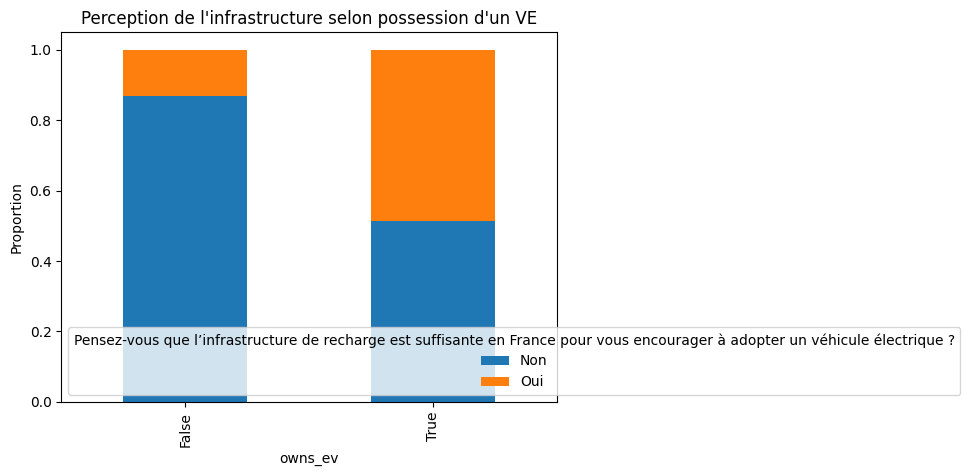

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?  Non  \
owns_ev                                                                                                                              
False                                                                                                                          173   
True                                                                                                                            17   

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?  Oui  
owns_ev                                                                                                                             
False                                                                                                                           26  
True                                                            

In [341]:
# 3.2 Perception de la suffisance de l’infrastructure
print(df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"].value_counts(dropna=False))

# 3.3 Croisement avec statut propriétaire VE
if 'owns_ev' not in df.columns:
    df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

pd.crosstab(df['owns_ev'], df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Perception de l'infrastructure selon possession d'un VE")
plt.ylabel("Proportion")
plt.show()

# ...existing code...
# 3.3 Croisement avec statut propriétaire VE
if 'owns_ev' not in df.columns:
    df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"] == True

ct = pd.crosstab(
    df['owns_ev'],
    df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"]
)
print(ct)

# Test du Chi² d'indépendance
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(ct)
print(f"\nTest du Chi² : p-value = {p:.4f}")
if p < 0.05:
    print("✅ La perception de l'infrastructure diffère significativement selon la possession d'un VE.")
else:
    print("❌ Pas de différence significative selon la possession d'un VE.")



In [342]:
# On retire les lignes où il manque une des deux variables
df_reg = df[['connaissance_score', 'intention_adopter']].dropna()

# Ajoute la constante (intercept)
X = sm.add_constant(df_reg['connaissance_score'])
y = df_reg['intention_adopter']

# Régression logistique
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.679991
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      intention_adopter   No. Observations:                  157
Model:                          Logit   Df Residuals:                      155
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 May 2025   Pseudo R-squ.:               0.0006234
Time:                        01:15:54   Log-Likelihood:                -106.76
converged:                       True   LL-Null:                       -106.83
Covariance Type:            nonrobust   LLR p-value:                    0.7152
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4618      0.418      1.104      0.270      -0.358       1.282
conna

Moyenne du nombre d'aides connues selon le score subjectif :
connaissance_score
1    1.050000
2    1.723404
3    1.725490
4    1.592593
Name: score_aides_connues, dtype: float64


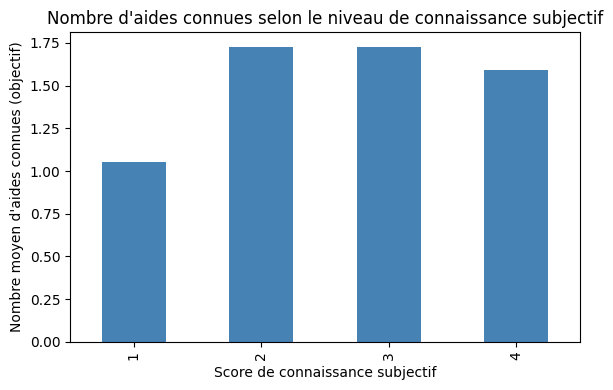

Moyenne du score subjectif selon le nombre d'aides connues :
score_aides_connues
0    2.757576
1    1.868852
2    2.347826
3    2.500000
4    2.500000
5    2.800000
6    2.714286
Name: connaissance_score, dtype: float64


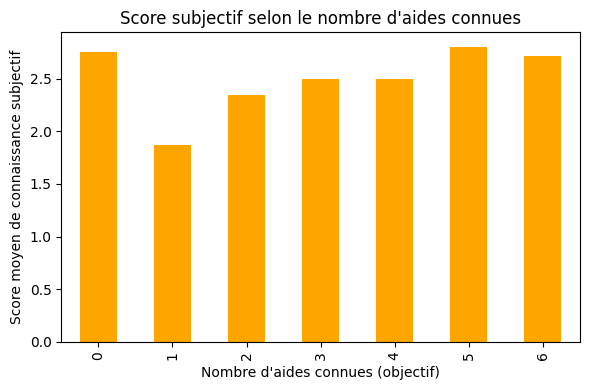

Corrélation r = 0.14, p-value = 0.0366
✅ Corrélation significative. La connaissance des aides est associée à la perception de la connaissance.
                             OLS Regression Results                            
Dep. Variable:     score_aides_connues   R-squared:                       0.019
Model:                             OLS   Adj. R-squared:                  0.015
Method:                  Least Squares   F-statistic:                     4.421
Date:                 Tue, 20 May 2025   Prob (F-statistic):             0.0366
Time:                         01:15:55   Log-Likelihood:                -402.21
No. Observations:                  232   AIC:                             808.4
Df Residuals:                      230   BIC:                             815.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      

In [343]:
# Moyenne du nombre d'aides connues selon le score subjectif
mean_aides_by_connaissance = df.groupby('connaissance_score')['score_aides_connues'].mean()
print("Moyenne du nombre d'aides connues selon le score subjectif :")
print(mean_aides_by_connaissance)

plt.figure(figsize=(6,4))
mean_aides_by_connaissance.plot(kind='bar', color='steelblue')
plt.xlabel("Score de connaissance subjectif")
plt.ylabel("Nombre moyen d'aides connues (objectif)")
plt.title("Nombre d'aides connues selon le niveau de connaissance subjectif")
plt.tight_layout()
plt.show()

# Moyenne du score subjectif selon le nombre d'aides connues
mean_connaissance_by_aides = df.groupby('score_aides_connues')['connaissance_score'].mean()
print("Moyenne du score subjectif selon le nombre d'aides connues :")
print(mean_connaissance_by_aides)

plt.figure(figsize=(6,4))
mean_connaissance_by_aides.plot(kind='bar', color='orange')
plt.xlabel("Nombre d'aides connues (objectif)")
plt.ylabel("Score moyen de connaissance subjectif")
plt.title("Score subjectif selon le nombre d'aides connues")
plt.tight_layout()
plt.show()

valid = df[['connaissance_score', 'score_aides_connues']].dropna()
r, p = pearsonr(valid['connaissance_score'], valid['score_aides_connues'])
print(f"Corrélation r = {r:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("✅ Corrélation significative. La connaissance des aides est associée à la perception de la connaissance.")
else:
    print("❌ Corrélation non significative. Pas de lien entre la connaissance des aides et la perception de la connaissance.")

import statsmodels.api as sm
X = sm.add_constant(valid['connaissance_score'])
y = valid['score_aides_connues']
model = sm.OLS(y, X).fit()
print(model.summary())

#

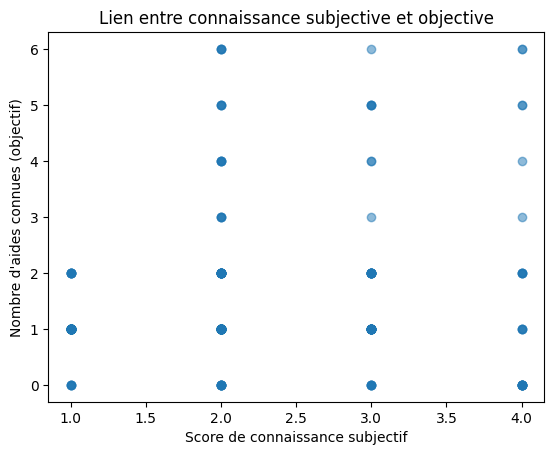

In [344]:
plt.scatter(df['connaissance_score'], df['score_aides_connues'], alpha=0.5)
plt.xlabel("Score de connaissance subjectif")
plt.ylabel("Nombre d'aides connues (objectif)")
plt.title("Lien entre connaissance subjective et objective")
plt.show()

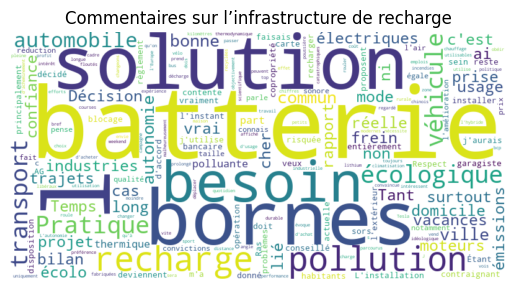

In [345]:
# 5.1 Nuage de mots sur les commentaires libres (remplace le nom de colonne si besoin)
from wordcloud import WordCloud
if "(Optionnel) Si vous souhaitez apporter des précisions :" in df.columns:
    # Liste de stopwords français de base
    stopwords = set(STOPWORDS)
    # Ajoute des mots spécifiques si besoin
    stopwords.update([
        "les","je", "des","très","sont", "aux","d'une","qu","1","1 ","suis","j'ai","être"," 1","n", "avec", "pour", "dans", "sur", "par", "que", "qui", "une", "du", "en", "et", "le", "la", "un", "au", "ce", "se", "ne", "pas", "plus", "ou", "mais", "est", "à", "de", "il", "elle", "vous", "nous", "ils", "elles", "moi", "toi", "lui", "eux", "soi", "y", "en", "tout", "tous", "toutes", "bien", "mal", "comme", "si", "aussi", "sans", "sous", "avant", "après"
        "lors", "entre", "parce", "que", "quoi", "comment", "où", "quand", "pourquoi", "qui", "quel", "quelle", "lesquels", "lesquelles", "celui", "celle", "ceux", "celles", "cela", "ça", "ceci", "cela", "là", "ici", "là-bas", "ailleurs", "telle", "tellement", "tel", "tels", "telles", "tellement"
        "toute", "toutes", "tout", "tous", "chaque", "aucun", "aucune", "nul", "nulle", "rien", "personne", "quelqu'un", "quelque chose", "certains", "certaines", "plusieurs", "beaucoup", "trop", "assez", "peu", "moins","mon", "ton", "son", "notre", "votre", "leur", "ma", "ta", "sa", "mes", "tes", "ses", "nos", "vos", "leurs", "lui-même", "elle-même", "eux-mêmes", "elles-mêmes","électrique","encore","faire","voiture","plutôt","aussi","même","autre","autres","tous","toutes","quelque","quelques","quelques-uns","quelques-unes","certains","certaines","car","d","donc","alors","ainsi","tandis","pendant","lorsque","si","comme","parce que","puisque","bien que","quoique","malgré","sauf","excepté","au-delà de", "au lieu de", "à part", "en dehors de", "à l'exception de", "hormis", "sauf que", "excepté que", "mis à part", "sans compter que", "en plus de"
    ])
    text = ' '.join(df["(Optionnel) Si vous souhaitez apporter des précisions :"].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Commentaires sur l’infrastructure de recharge")
    plt.show()

In [346]:
infra_col = "Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"
geo_col = "Habitez-vous dans :"

# Nettoyage
df[infra_col] = df[infra_col].str.strip()
df[geo_col] = df[geo_col].str.strip()

# Tableau croisé
ct = pd.crosstab(df[geo_col], df[infra_col])
print(ct)

# Test du Chi²
chi2, p, dof, _ = chi2_contingency(ct)
print(f"\nChi² = {chi2:.2f} | p = {p:.4f}")


Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?  Non  \
Habitez-vous dans :                                                                                                                  
Une grande ville                                                                                                                64   
Une ville moyenne                                                                                                               61   
Une zone périurbaine                                                                                                            37   
Une zone rurale                                                                                                                 28   

Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?  Oui  
Habitez-vous dans :                                           

Quels types de problèmes rencontrez-vous ? (Borne en panne)                                  0.025862
Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)                0.021552
Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)                0.012931
Quels types de problèmes rencontrez-vous ? (Borne occupée)                                   0.021552
Quels types de problèmes rencontrez-vous ? (Incompatibilité de connecteur ou application)    0.025862
Quels types de problèmes rencontrez-vous ? (Manque d’informations sur les bornes)            0.004310
dtype: float64
Quels types de problèmes rencontrez-vous ? (Borne en panne)                                  6
Quels types de problèmes rencontrez-vous ? (Paiement impossible ou compliqué)                5
Quels types de problèmes rencontrez-vous ? (File d’attente / temps d’attente)                3
Quels types de problèmes rencontrez-vous ? (Borne occupée)                              

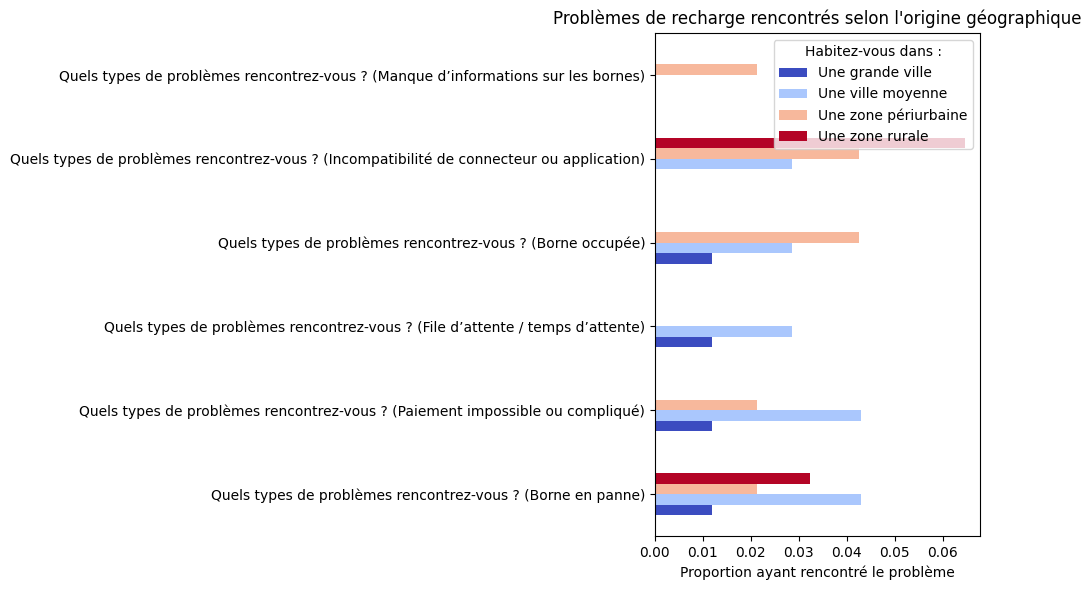

In [347]:
print(df[pb_cols].mean())
print(df[pb_cols].sum())
print(df["Habitez-vous dans :"].value_counts())
print(df[pb_cols + ["Habitez-vous dans :"]].head(10))
# Moyenne par lieu
problem_by_geo = df.groupby("Habitez-vous dans :")[pb_cols].mean().T
problem_by_geo.plot(kind='barh', figsize=(10,6), colormap='coolwarm')
plt.title("Problèmes de recharge rencontrés selon l'origine géographique")
plt.xlabel("Proportion ayant rencontré le problème")
plt.tight_layout()
plt.show()


Corrélation entre perception positive de l'infrastructure et intention d'adopter : r = 0.05
Moyenne intention (infrastructure OK): 1.57
Moyenne intention (infrastructure pas OK): 1.42
T-test: t = 0.57, p = 0.5726


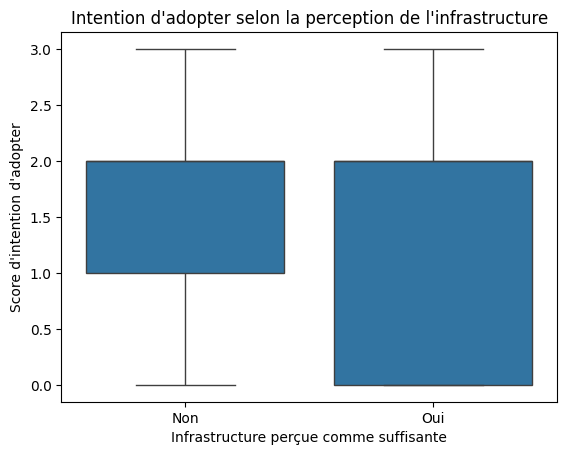

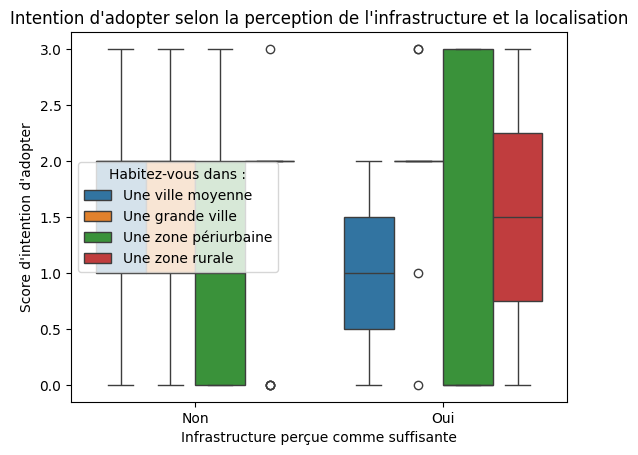

In [348]:
# Mapping intention + perception infrastructure
intention_col = "Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"
df['intention_score'] = df[intention_col].map({
    "Totalement d'accord": 3,
    "Plutôt d'accord": 2,
    "Plutôt en désaccord": 1,
    "Totalement en désaccord": 0
})


df['infra_ok'] = df[infra_col].map({'Oui': 1, 'Non': 0})

corr = df[['intention_score', 'infra_ok']].dropna().corr().iloc[0,1]
print(f"Corrélation entre perception positive de l'infrastructure et intention d'adopter : r = {corr:.2f}")


group_yes = df[df['infra_ok'] == 1]['intention_score'].dropna()
group_no = df[df['infra_ok'] == 0]['intention_score'].dropna()
tstat, pval = ttest_ind(group_yes, group_no, equal_var=False)
print(f"Moyenne intention (infrastructure OK): {group_yes.mean():.2f}")
print(f"Moyenne intention (infrastructure pas OK): {group_no.mean():.2f}")
print(f"T-test: t = {tstat:.2f}, p = {pval:.4f}")

sns.boxplot(x='infra_ok', y='intention_score', data=df)
plt.xticks([0,1], ['Non', 'Oui'])
plt.xlabel("Infrastructure perçue comme suffisante")
plt.ylabel("Score d'intention d'adopter")
plt.title("Intention d'adopter selon la perception de l'infrastructure")
plt.show()

sns.boxplot(x='infra_ok', y='intention_score', hue='Habitez-vous dans :', data=df)
plt.xticks([0,1], ['Non', 'Oui'])
plt.xlabel("Infrastructure perçue comme suffisante")
plt.ylabel("Score d'intention d'adopter")
plt.title("Intention d'adopter selon la perception de l'infrastructure et la localisation")
plt.show()

[('prix', 232), ('Centralisation des infos (application', 208), ('disponibilité)', 192), ('Meilleure maintenance du réseau', 162), ('Uniformisation des connecteurs', 161), ('Plus de recharge rapide', 156), ('Paiement simplifié', 152), ('Plus de bornes', 131), ('Meilleure maintenance du réseau Plus de bornes', 23), ('Paiement simplifié Plus de bornes', 22)]


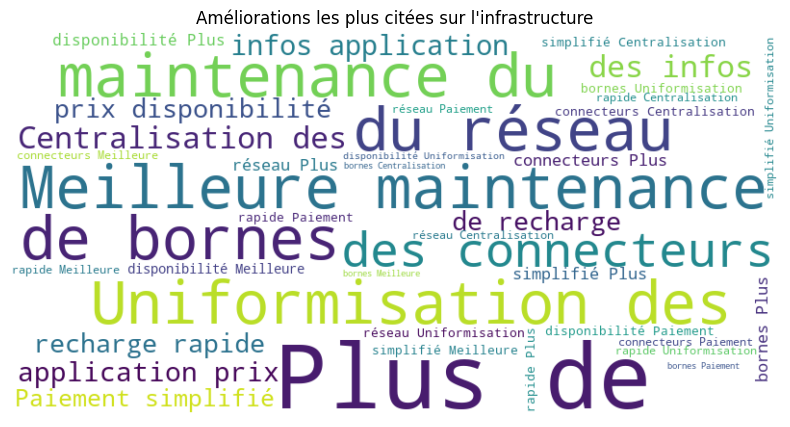

In [349]:
from collections import Counter
from wordcloud import WordCloud

priority_col = "Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge"
all_text = ' '.join(df[priority_col].dropna().tolist())
counter = Counter(all_text.split(", "))
print(counter.most_common(10))

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Améliorations les plus citées sur l'infrastructure")
plt.show()


----
# F.	Social and Informational Influences

In [350]:
peer_cols = [
    "Combien de personnes dans votre entourage utilisent un véhicule électrique ?\n",
    "Vous diriez que [Vous avez déjà échangé sur le sujet des véhicules électriques avec votre entourage]",
    "Vous diriez que [l'avis de votre entourage vous à encourager dans l'adoption du véhicule électrique]",
    "Vous diriez que [L'avis de votre entourage est positif envers le véhicule électrique]",
    "Vous diriez que [Échanger avec eux vous a rassuré ou motivé sur ce sujet]"
]
for col in peer_cols:
    print(f"\n{col}")
    print(df[col].value_counts(dropna=False))
    if df[col].dtype == object:
        # Recoder Oui/Non si besoin
        df[col + "_bin"] = df[col].map({"Oui": 1, "Non": 0, "Vaguement": 0.5, "Je ne sais pas": np.nan})
        group = df.groupby(col + "_bin")["intention_adopter"].mean()
        print("Intention d'adopter selon ce facteur :\n", group)


for col in peer_cols[1:]:  # Sauf la première qui est quantitative
    group1 = df[df[col + "_bin"] == 1]["intention_adopter"].dropna()
    group0 = df[df[col + "_bin"] == 0]["intention_adopter"].dropna()
    if len(group1) > 1 and len(group0) > 1:
        tstat, pval = ttest_ind(group1, group0, equal_var=False)
        print(f"{col} : t = {tstat:.2f}, p = {pval:.4f}")
        if pval < 0.05:
            print("✅ Différence significative entre les groupes.")
        else:
            print("❌ Pas de différence significative entre les groupes.")

try:
    entourage_nb = pd.to_numeric(df[peer_cols[0]], errors='coerce')
    corr = entourage_nb.corr(df['intention_adopter'])
    print(f"Corrélation entre nombre d'utilisateurs VE dans l'entourage et intention d'adopter : r = {corr:.2f}")
except Exception as e:
    print("Erreur de calcul de corrélation :", e)


Combien de personnes dans votre entourage utilisent un véhicule électrique ?

Combien de personnes dans votre entourage utilisent un véhicule électrique ?\n
Peu (1 à 3)             121
Aucune                   64
Plusieurs (3 à 5)        30
Beaucoup (plus de 5)     17
Name: count, dtype: int64
Intention d'adopter selon ce facteur :
 Series([], Name: intention_adopter, dtype: float64)

Vous diriez que [Vous avez déjà échangé sur le sujet des véhicules électriques avec votre entourage]
Vous diriez que [Vous avez déjà échangé sur le sujet des véhicules électriques avec votre entourage]
Totalement d'accord        110
Plutôt d'accord             82
Plutôt en désaccord         28
Totalement en désaccord     12
Name: count, dtype: int64
Intention d'adopter selon ce facteur :
 Series([], Name: intention_adopter, dtype: float64)

Vous diriez que [l'avis de votre entourage vous à encourager dans l'adoption du véhicule électrique]
Vous diriez que [l'avis de votre entourage vous à encourager dans

In [351]:
for col in ["Vous diriez que [L'avis de votre entourage est positif envers le véhicule électrique]", "Vous diriez que [Échanger avec eux vous a rassuré ou motivé sur ce sujet]"]:
    # Mappe les 4 options d'accord/désaccord sur une échelle 0-3
    map4 = {
        "Totalement en désaccord": 0,
        "Plutôt en désaccord": 1,
        "Plutôt d'accord": 2,
        "Totalement d'accord": 3
    }
    df[col + "_bin"] = df[col].map(map4)
    group1 = df[df[col + "_bin"] == 3]["intention_adopter"].dropna()
    group0 = df[df[col + "_bin"] == 0]["intention_adopter"].dropna()
    print(f"{col} - n1: {len(group1)}, n0: {len(group0)}, unique1: {group1.unique()}, unique0: {group0.unique()}")
    print(f"Var group1: {group1.var()}, Var group0: {group0.var()}")
    if len(group1) > 1 and len(group0) > 1:
        tstat, pval = ttest_ind(group1, group0, equal_var=False)
        print(f"{col} : t = {tstat:.2f}, p = {pval:.4f}")
    else:
        print(f"{col} : Pas assez de données pour le t-test.")

Vous diriez que [L'avis de votre entourage est positif envers le véhicule électrique] - n1: 15, n0: 9, unique1: [1. 0.], unique0: [0. 1.]
Var group1: 0.17142857142857146, Var group0: 0.19444444444444445
Vous diriez que [L'avis de votre entourage est positif envers le véhicule électrique] : t = 3.18, p = 0.0058
Vous diriez que [Échanger avec eux vous a rassuré ou motivé sur ce sujet] - n1: 10, n0: 22, unique1: [1. 0.], unique0: [0. 1.]
Var group1: 0.1, Var group0: 0.08658008658008656
Vous diriez que [Échanger avec eux vous a rassuré ou motivé sur ce sujet] : t = 6.85, p = 0.0000


In [352]:
clarity_col = "Ces sources vous paraissent-elles claires et fiables ?\n"
df["clarity_bin"] = df[clarity_col].map({"Oui, j’ai facilement trouvé ce que je cherchais": 1, "Pas toujours, il faut croiser les infos et c'était plutôt complexe de comprendre les offres et véhicules disponible sur le marché": 0})
group = df.groupby("clarity_bin")["intention_adopter"].mean()
print("Intention d'adopter selon la clarté perçue des sources :\n", group)

Intention d'adopter selon la clarté perçue des sources :
 clarity_bin
0.0    0.629213
1.0    0.692308
Name: intention_adopter, dtype: float64


In [353]:
brand_col = "Quelles marques vous semblent proposer une offre électrique claire et bien communiquée ?\n"
brands = df[brand_col].dropna().str.split(',').explode().str.strip()
brand_counts = brands.value_counts()
print("Marques les plus citées :\n", brand_counts.head(10))

Marques les plus citées :
 Quelles marques vous semblent proposer une offre électrique claire et bien communiquée ?\n
Tesla         97
Renault       76
Peugeot       47
BYD           41
Aucune        32
BMW           25
Kia           25
Volkswagen    24
Hyundai       24
Mercedes      20
Name: count, dtype: int64


In [354]:
info_col = "Où avez-vous cherché (ou chercheriez-vous) des informations sur les véhicules électriques ?\n"
sources = df[info_col].dropna().str.split(',').explode().str.strip()
source_counts = sources.value_counts()
print("Sources d'information les plus utilisées :\n", source_counts.head(10))

Sources d'information les plus utilisées :
 Où avez-vous cherché (ou chercheriez-vous) des informations sur les véhicules électriques ?\n
Entourage (amis                               125
collègues…)                                   125
Sites des constructeurs / Concessionnaires    111
Médias généralistes / spécialisés             105
Comparateurs de véhicules                      74
Forums / avis en ligne                         64
Réseaux sociaux                                42
Salons ou événements                           23
Non                                             2
YouTube / Influenceurs automobile               2
Name: count, dtype: int64


In [355]:
from scipy.stats import ttest_ind, f_oneway

# H2 : ANOVA ou t-test selon l'âge, la CSP, la zone géographique
for var in ["Dans quelle tranche d’âge vous situez-vous ?\n", "Habitez-vous dans :", "Quelle est votre situation professionnelle actuelle ?\n"]:
    print(f"\nEffet de {var} sur l'intention d'adopter :")
    groups = [g["intention_adopter"].dropna() for _, g in df.groupby(var) if g["intention_adopter"].notna().sum() > 1]
    if len(groups) >= 2:
        fval, pval = f_oneway(*groups)
        print(f"ANOVA: F = {fval:.2f}, p = {pval:.4f}")
        # Analyse automatique
        if pval < 0.05:
            print("✅ Il existe une différence significative de l'intention d'adopter selon cette variable.")
            means = [g.mean() for g in groups]
            print(f"  Moyennes par groupe : {means}")
        else:
            print("❌ Pas de différence significative de l'intention d'adopter selon cette variable.")
    else:
        print("Pas assez de groupes pour faire une ANOVA valide.")

# H3 : t-test clarté perçue vs intention
group1 = df[df["clarity_bin"] == 1]["intention_adopter"].dropna()
group0 = df[df["clarity_bin"] == 0]["intention_adopter"].dropna()
tstat, pval = ttest_ind(group1, group0, equal_var=False)
print(f"H3 - Clarté perçue : t = {tstat:.2f}, p = {pval:.4f}")
# Analyse automatique
if pval < 0.05:
    print("✅ L'intention d'adopter est significativement plus élevée chez ceux qui trouvent les sources claires et fiables.")
    print(f"  Moyenne (sources claires) : {group1.mean():.2f}")
    print(f"  Moyenne (sources peu claires) : {group0.mean():.2f}")
else:
    print("❌ Pas de différence significative d'intention d'adopter selon la clarté perçue des sources.")


Effet de Dans quelle tranche d’âge vous situez-vous ?
 sur l'intention d'adopter :
ANOVA: F = 0.80, p = 0.5719
❌ Pas de différence significative de l'intention d'adopter selon cette variable.

Effet de Habitez-vous dans : sur l'intention d'adopter :
ANOVA: F = 2.77, p = 0.0435
✅ Il existe une différence significative de l'intention d'adopter selon cette variable.
  Moyennes par groupe : [np.float64(0.6451612903225806), np.float64(0.5111111111111111), np.float64(0.41379310344827586), np.float64(0.7619047619047619)]

Effet de Quelle est votre situation professionnelle actuelle ?
 sur l'intention d'adopter :
ANOVA: F = 0.44, p = 0.7821
❌ Pas de différence significative de l'intention d'adopter selon cette variable.
H3 - Clarté perçue : t = 0.60, p = 0.5538
❌ Pas de différence significative d'intention d'adopter selon la clarté perçue des sources.


----
# G.	Consumer Knowledge and Understanding

In [ ]:
# 1. Statistiques descriptives sur la compréhension auto-déclarée
comprehension_cols = [
    "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]",
    "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Les aspects pratiques d’un véhicule électrique sont clairs pour moi (ex. : recharge, autonomie, entretien)]",
]
# 1. Extraction des types de bornes connues (multi-réponses)
bornes_col = "Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?"
df[bornes_col] = df[bornes_col].astype(str)
# Oui, c'est utile ici pour extraire toutes les modalités uniques de bornes connues
all_answers = df[bornes_col].dropna().apply(lambda x: [ans.strip() for ans in x.split(',') if ans.strip() and ans.lower() != 'nan'])
flat_answers = [item for sublist in all_answers for item in sublist]
modalites = sorted(set(flat_answers))
# Création de colonnes binaires pour chaque modalité
for mod in modalites:
    df[f"borne_{mod}"] = df[bornes_col].str.contains(mod, regex=False).astype(int)

# Statistiques descriptives
for mod in modalites:
    print(f"{mod} : {df[f'borne_{mod}'].mean()*100:.1f}% des répondants")

# Croisement avec la localisation
geo_col = "Habitez-vous dans :"
for mod in modalites:
    cross = pd.crosstab(df[geo_col], df[f"borne_{mod}"], normalize='index')
    print(f"\nRépartition '{mod}' par zone :")
    print((cross*100).round(1))
for col in comprehension_cols:
    print(f"\n{col}")
    print(df[col].value_counts(dropna=False))
    # Map Likert responses to numeric if needed
    if df[col].dtype == object:

        col_num = df[col].map(likert_map)
    else:
        col_num = df[col]
    print(f"Moyenne: {col_num.mean():.2f} | % d'accord (>=4): {(col_num>=4).mean()*100:.1f}%")
    

Non : 23.7% des répondants
Oui : 77.2% des répondants
des bornes "privées" (Supermarché : 51.3% des répondants
des bornes publiques : 47.4% des répondants
je n'en vois pas : 23.7% des répondants
lieu de travail...) : 51.3% des répondants
résidence...) : 19.4% des répondants
à domicile (maison : 19.4% des répondants

Répartition 'Non' par zone :
borne_Non                0     1
Habitez-vous dans :             
Une grande ville      72.6  27.4
Une ville moyenne     77.1  22.9
Une zone périurbaine  76.6  23.4
Une zone rurale       83.9  16.1

Répartition 'Oui' par zone :
borne_Oui                0     1
Habitez-vous dans :             
Une grande ville      27.4  72.6
Une ville moyenne     21.4  78.6
Une zone périurbaine  21.3  78.7
Une zone rurale       16.1  83.9

Répartition 'des bornes "privées" (Supermarché' par zone :
borne_des bornes "privées" (Supermarché     0     1
Habitez-vous dans :                                
Une grande ville                         54.8  45.2
Une ville m

In [359]:
for col in comprehension_cols:
    print(f"\n{col}")
    for mod in modalites:
        mean = df.groupby(f"borne_{mod}")[col].value_counts(normalize=True)
        print(f"  {mod} :\n{mean}")


Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?
 [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]
  Non :
borne_Non  Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]
0          Plutôt d'accord                                                                                                                                                                              0.572414
           Tout à fait d'accord                                                                                                                                                                         0.337931
           Plutôt en désaccord                                                                                                                                                                 


--- Analyse pour prise en main ---
Corrélation score ↔ intention d'adopter : r = 0.18, p = 0.0715


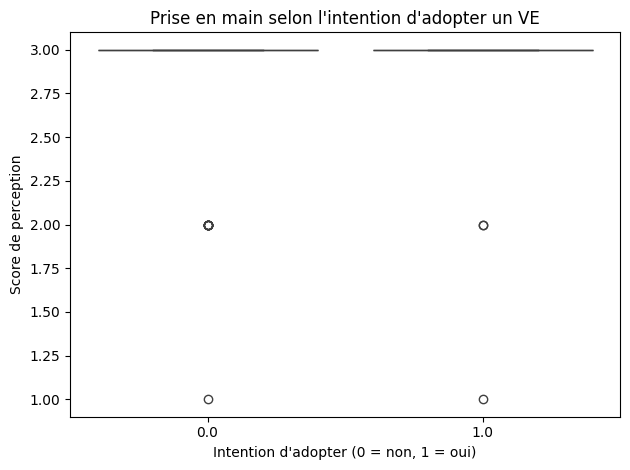

Pas assez de données pour le test d'expérience de conduite.
Score moyen selon expérience de conduite :
has_driven_ev
1.0    2.87
Name: prise_en_main_score, dtype: float64

--- Analyse pour aspects pratiques ---
Corrélation score ↔ intention d'adopter : r = 0.34, p = 0.0001


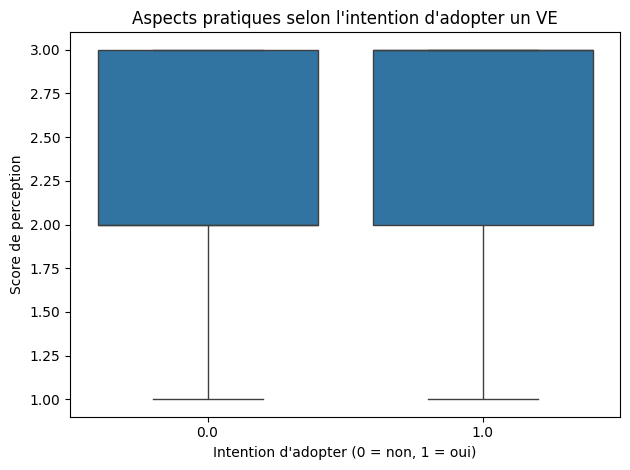

Pas assez de données pour le test d'expérience de conduite.
Score moyen selon expérience de conduite :
has_driven_ev
1.0    2.48
Name: aspects_pratiques_score, dtype: float64


In [368]:

# 1. Colonnes de perception (Likert)
info_cols = {
    "prise_en_main": "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]",
    "aspects_pratiques": "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Les aspects pratiques d’un véhicule électrique sont clairs pour moi (ex. : recharge, autonomie, entretien)]"
}

# 2. Intention d'adopter un VE
intention_col = "Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"
intention_map = {
    "Oui": 1, "Plutôt d'accord": 1, "Totalement d'accord": 1,
    "Non": 0, "Plutôt en désaccord": 0, "Totalement en désaccord": 0
}

# 3. Expérience de conduite
drive_exp_col = "Avez-vous déjà eu l’occasion de conduire ou de monter dans un véhicule électrique ?"
drive_exp_map = {
    "Oui, j’ai conduit": 1,
    "Oui, j’étais passager": 1,
    "Non": 0
}

# 4. Recodage des Likert
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Totalement d'accord": 4
}

# 5. Recodage
df['intention_adopter'] = df[intention_col].map(intention_map)
df['has_driven_ev'] = df[drive_exp_col].map(drive_exp_map)

for key, col in info_cols.items():
    df[f"{key}_score"] = df[col].map(likert_map)

# 6. Analyse logique et complète
for key in info_cols:
    score_col = f"{key}_score"
    print(f"\n--- Analyse pour {key.replace('_', ' ')} ---")
    # Corrélation avec intention
    valid = df[[score_col, 'intention_adopter']].dropna()
    if not valid.empty:
        r, p = pearsonr(valid[score_col], valid['intention_adopter'])
        print(f"Corrélation score ↔ intention d'adopter : r = {r:.2f}, p = {p:.4f}")
    # Boxplot
    sns.boxplot(x='intention_adopter', y=score_col, data=df)
    plt.title(f"{key.replace('_', ' ').capitalize()} selon l'intention d'adopter un VE")
    plt.xlabel("Intention d'adopter (0 = non, 1 = oui)")
    plt.ylabel("Score de perception")
    plt.tight_layout()
    plt.show()
    # Test de normalité
    group1 = df[df['has_driven_ev'] == 1][score_col].dropna()
    group0 = df[df['has_driven_ev'] == 0][score_col].dropna()
    if len(group1) > 2 and len(group0) > 2:
        stat1, p1 = shapiro(group1)
        stat0, p0 = shapiro(group0)
        print(f"Normalité (expérience): p={p1:.3f} | (pas d'expérience): p={p0:.3f}")
        # Test de variance
        var1, var0 = np.var(group1), np.var(group0)
        print(f"Variance (expérience): {var1:.2f} | (pas d'expérience): {var0:.2f}")
        # Test de Student ou Mann-Whitney selon normalité
        if p1 > 0.05 and p0 > 0.05:
            t, p = ttest_ind(group1, group0, equal_var=False)
            test_used = "t-test"
        else:
            t, p = mannwhitneyu(group1, group0, alternative='two-sided')
            test_used = "Mann-Whitney"
        print(f"{test_used} : stat = {t:.2f}, p = {p:.4f}")
        # Effet taille (Cohen's d)
        d = (group1.mean() - group0.mean()) / np.sqrt((var1 + var0) / 2)
        print(f"Effet taille (Cohen's d) : {d:.2f}")
        # Interprétation automatique
        if p < 0.05:
            print("✅ Différence significative selon l'expérience de conduite d'un VE.")
        else:
            print("❌ Pas de différence significative selon l'expérience de conduite d'un VE.")
    else:
        print("Pas assez de données pour le test d'expérience de conduite.")
    # Moyennes
    print("Score moyen selon expérience de conduite :")
    print(df.groupby('has_driven_ev')[score_col].mean().round(2))

In [369]:
# 3. Corrélation entre connaissance et attitude positive
from scipy.stats import pearsonr

valid = df[['connaissance_score', 'intention_adopter']].dropna()
r, p = pearsonr(valid['connaissance_score'], valid['intention_adopter'])
print(f"Corrélation connaissance <-> intention d'adopter : r = {r:.2f}, p = {p:.4f}")

# Comparaison par niveau de connaissance (faible/moyen/élevé)
df['niveau_connaissance'] = pd.cut(df['connaissance_score'], bins=[0,1.5,2.5,4], labels=['Faible','Moyen','Élevé'])
print(df.groupby('niveau_connaissance')['intention_adopter'].mean())

Corrélation connaissance <-> intention d'adopter : r = -0.03, p = 0.7171
niveau_connaissance
Faible    0.463415
Moyen     0.724638
Élevé     0.468085
Name: intention_adopter, dtype: float64


C:\Users\Mango\AppData\Local\Temp\ipykernel_23496\2736024798.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('niveau_connaissance')['intention_adopter'].mean())


In [370]:
# 4. Analyse du classement des facteurs
priority_col = "Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge"
from collections import Counter

# Extraction du facteur cité en premier
first_factors = df[priority_col].dropna().apply(lambda x: x.split(",")[0].strip())
print("Facteur cité en 1ère priorité :")
print(first_factors.value_counts())

# Extraction du facteur cité en 2ème priorité
second_factors = df[priority_col].dropna().apply(lambda x: x.split(",")[1].strip() if len(x.split(","))>1 else None)
print("\nFacteur cité en 2ème priorité :")
print(second_factors.value_counts())

Facteur cité en 1ère priorité :
Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge
Plus de bornes                           85
Plus de recharge rapide                  55
Uniformisation des connecteurs           43
Centralisation des infos (application    24
Paiement simplifié                       13
Meilleure maintenance du réseau          12
Name: count, dtype: int64

Facteur cité en 2ème priorité :
Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge
Plus de bornes                           50
Plus de recharge rapide                  50
Centralisation des infos (application    33
Uniformisation des connecteurs           32
prix                                     24
Paiement simplifié                       23
Meilleure maintenance du réseau          20
Name: count, dtype: int64


In [371]:
# Croisement classement 1er facteur x niveau de connaissance
cross = pd.crosstab(first_factors, df.loc[first_factors.index, 'niveau_connaissance'])
print("\nClassement du 1er facteur selon le niveau de connaissance :")
print(cross)


Classement du 1er facteur selon le niveau de connaissance :
niveau_connaissance                                 Faible  Moyen  Élevé
Classez ces points par priorité du plus crucial...                      
Centralisation des infos (application                    6      8     10
Meilleure maintenance du réseau                          5      3      4
Paiement simplifié                                       4      3      6
Plus de bornes                                          19     36     30
Plus de recharge rapide                                 15     23     17
Uniformisation des connecteurs                          11     21     11


----
# I.	Cross-Factor Interactions & Insights